In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Probabilities of Default (PDs) - Expected PDs

<img src="dcr.png" alt="title1" width="1150"/>

# Setup

In [2]:
import warnings; warnings.simplefilter('ignore')
from dcr import *
data, data_train, data_test, X_train_scaled, X_test_scaled, y_train, y_test = dataprep(data, depvar='default_time', splitvar='time', threshold=26)

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams.update({'font.size': 16})

ModuleNotFoundError: No module named 'pydot'

# Synopsis

 - Default outcome
 - Features and selection
 - Default models: probability of default 
 - PD prediction

# Outcome variable `default_time`

 - Payment delinquency of 30, 60 and 90 days or more;
 - Bankruptcy of the borrower;
 - Collateral owned by a bank, e.g., real estate owned after an unsuccessful sale at a foreclosure auction;
 - Foreclosure of loan;
 - Short sale of loan;
 - Loss/write-down amount;
 - Involuntary liquidation;
 - Debt modification as a positive interest, expense, or principle forgiveness.

\begin{align*}
     D_{it} =
  	\begin{cases}
  		1 & \text{borrower } i \text{ defaults at time } t\cr
  		0 & \text{otherwise}
  	\end{cases}
\end{align*}


## Defaulter in period 37 (id=9) and non-defaulter (id=47)

In [4]:
import pandas as pd 
data = pd.read_csv('C:/Users/Rachel/Documents/Raquel/Masterclass on PD Machine Learning in Python/dcr.csv')

data = data.sort_values(by=['id', 'time'])

print(data.loc[(data.id==9)|(data.id==47),['id', 'time', 'default_time']])

    id  time  default_time
35   9    25             0
36   9    26             0
37   9    27             0
38   9    28             0
39   9    29             0
40   9    30             0
41   9    31             0
42   9    32             0
43   9    33             0
44   9    34             0
45   9    35             0
46   9    36             0
47   9    37             1
48  47    25             0
49  47    26             0
50  47    27             0


## Probabilities of default

 - Discrete time periods
 - Default occurs with probability $P(D_{it}=1) = PD_{it}$
 - Non-default occurs with probability $1-PD_{it}$
 - PD is the expected default outcome

\begin{align*}
E(D_{it})=PD_{it}*1+(1-PD_{it})*0 = PD_{it}
\end{align*}


## Other outcomes

 - Non-default and non-payoff (outcome 0)
 - Default (outcome 1)
 - Payoff (outcome 2)
 - Maturity (outcome 3)

In [5]:
c = [[(0,0),(1,0)],[(0,0),(1,1)],[(0,0),(1,2)],[(0,0),(1,3)],[(1,0),(2,0)],[(1,0),(2,1)],[(1,0),(2,2)],[(1,0),(2,3)]]

fig = plt.figure()
ax = fig.add_subplot(111)

annotated = set()
for l in c:
    d = [[p[0] for p in l], [p[1] for p in l]]
    ax.plot(d[0], d[1], 'k-*')
    for p in l:
        annotated.add(p) 

for p in annotated: 
    ax.annotate(str(p), xy=p)

plt.xlabel('Period')
plt.xlim([-1, 3])
plt.xticks([0, 1, 2])
plt.ylabel('Outcome')
plt.ylim([-1, 4])
plt.yticks([0, 1, 2, 3])
plt.show()
plt.clf()

NameError: name 'plt' is not defined

# Features

 - Idiosyncratic factors: features for borrowers, lender, guarantors or collateral
 - Time-varying externalities: macroeconomy
 - Time-constant externalities: market infrastructure and regulations


## Liquidity

In [9]:
import numpy as np
time = np.arange(20,140,1)
example=pd.DataFrame(data=time, index=time, columns=["time"])
example.loc[:, 'orig_time'] = 20

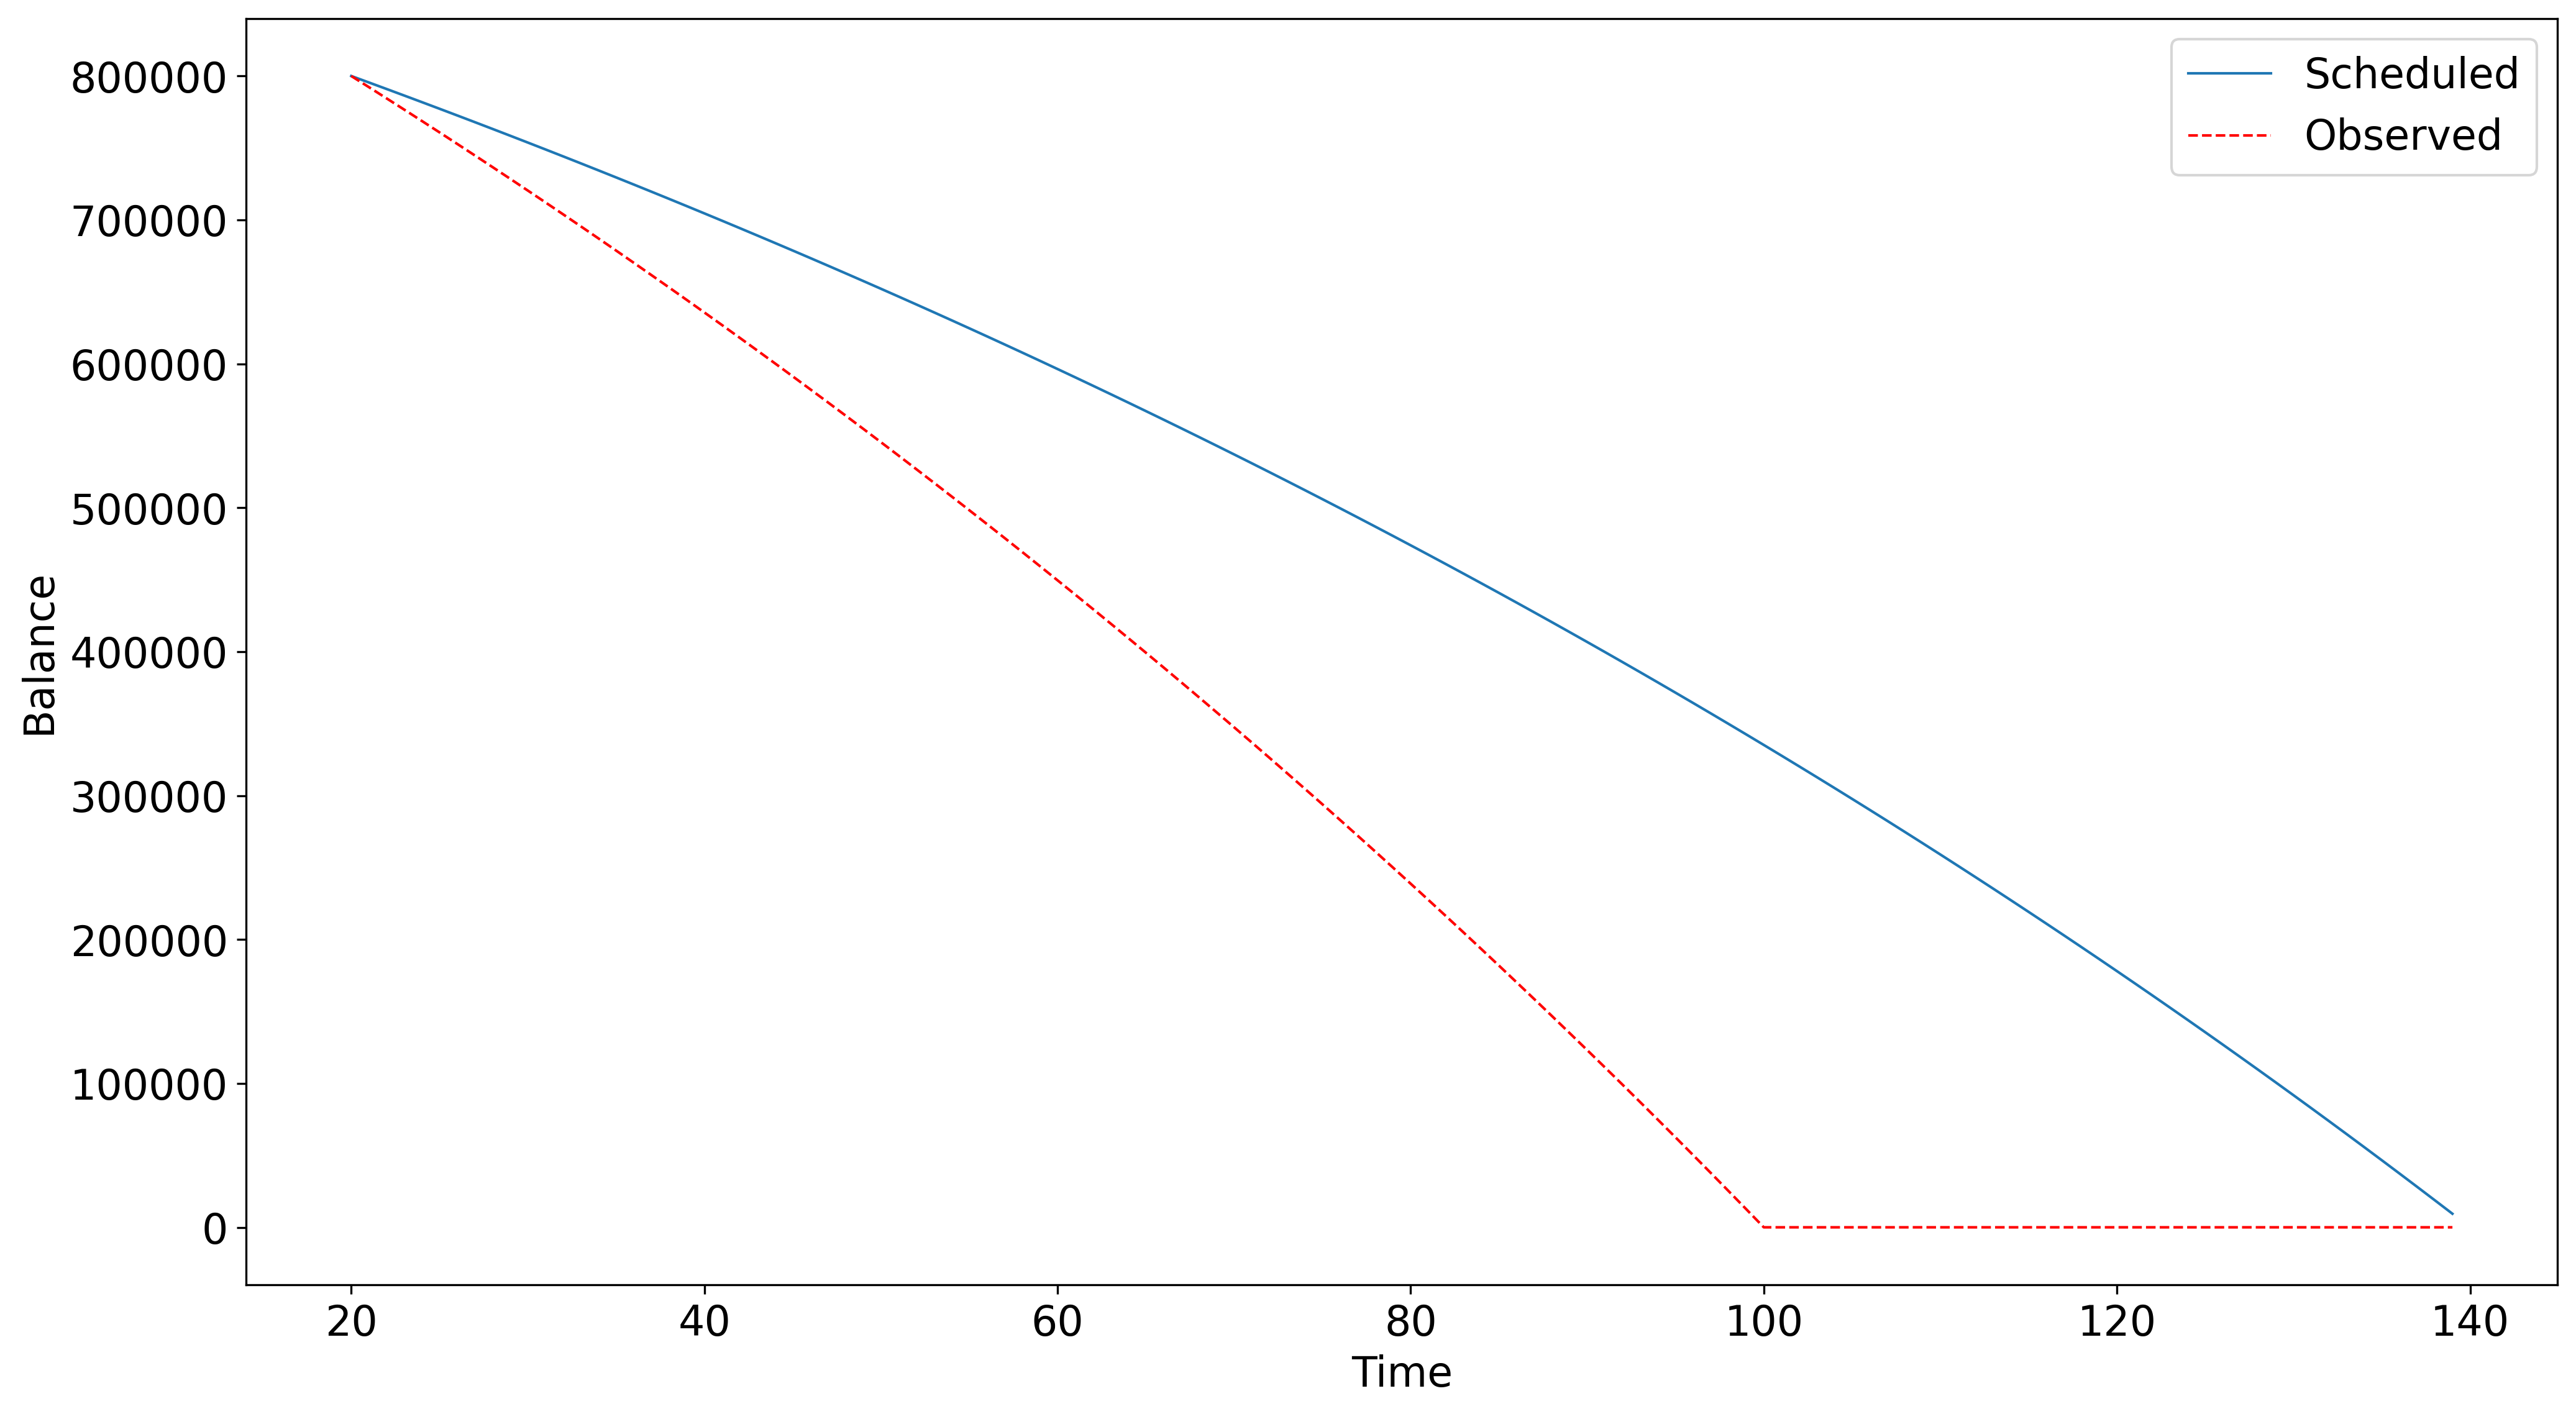

In [91]:
time = np.arange(20,140,1)
example=pd.DataFrame(data=time, index=time, columns=["time"])

example.loc[:, 'orig_time'] = 20
example.loc[:, 'mat_time'] = 140
example.loc[:, 'mat_time_observed'] = 100
example.loc[:, 'balance_orig_time'] = 800000
example.loc[:, 'interest_rate_time'] = 2.5

example.loc[:, 'annuity'] = ((example.loc[:,'interest_rate_time']/(100*4)) * example.loc[:,'balance_orig_time']) / (1-(1+example.loc[:,'interest_rate_time']/(100*4))**(-(example.loc[:,'mat_time'] - example.loc[:,'orig_time'])))
example.loc[:, 'annuity_observed'] = ((example.loc[:,'interest_rate_time']/(100*4)) * example.loc[:,'balance_orig_time']) / (1-(1+example.loc[:,'interest_rate_time']/(100*4))**(-(example.loc[:,'mat_time_observed'] - example.loc[:,'orig_time'])))

example.loc[:,'balance_scheduled_time']  = example.loc[:,'balance_orig_time'] * (1+example.loc[:,'interest_rate_time']/(100*4))**(example.loc[:,'time'] - example.loc[:,'orig_time']) - example.loc[:,'annuity'] * ((1+example.loc[:,'interest_rate_time']/(100*4))**(example.loc[:,'time']-example.loc[:,'orig_time'])-1) / (example.loc[:,'interest_rate_time']/(100*4))
example.loc[:,'balance_time']  = example.loc[:,'balance_orig_time'] * (1+example.loc[:,'interest_rate_time']/(100*4))**(example.loc[:,'time'] - example.loc[:,'orig_time']) - example.loc[:,'annuity_observed'] * ((1+example.loc[:,'interest_rate_time']/(100*4))**(example.loc[:,'time']-example.loc[:,'orig_time'])-1) / (example.loc[:,'interest_rate_time']/(100*4))
example = example.clip(lower=0)

plt.plot('time', 'balance_scheduled_time', data=example, linewidth=1, label='Scheduled')
plt.plot('time', 'balance_time', data=example, color='red', linewidth=1, label='Observed',linestyle='dashed')
plt.xlabel('Time') 
plt.ylabel('Balance')
plt.legend(loc='best')
plt.show()

In [92]:
data.loc[:, 'annuity'] = ((data.loc[:,'interest_rate_time']/(100*4)) * data.loc[:,'balance_orig_time']) / (1-(1+data.loc[:,'interest_rate_time']/(100*4))**(-(data.loc[:,'mat_time'] - data.loc[:,'orig_time'])))

data.loc[:,'balance_scheduled_time']  = data.loc[:,'balance_orig_time'] * (1+data.loc[:,'interest_rate_time']/(100*4))**(data.loc[:,'time'] - data.loc[:,'orig_time']) - data.loc[:,'annuity'] * ((1+data.loc[:,'interest_rate_time']/(100*4))**(data.loc[:,'time']-data.loc[:,'orig_time'])-1) / (data.loc[:,'interest_rate_time']/(100*4))


In [93]:
data.loc[:,'property_orig_time'] = np.maximum(data.loc[:,'balance_orig_time'] / (data.loc[:,'LTV_orig_time']/100),100000)

data.loc[:,'cep_time']= (data.loc[:,'balance_scheduled_time'] - data.loc[:,'balance_time']) / data.loc[:,'property_orig_time']

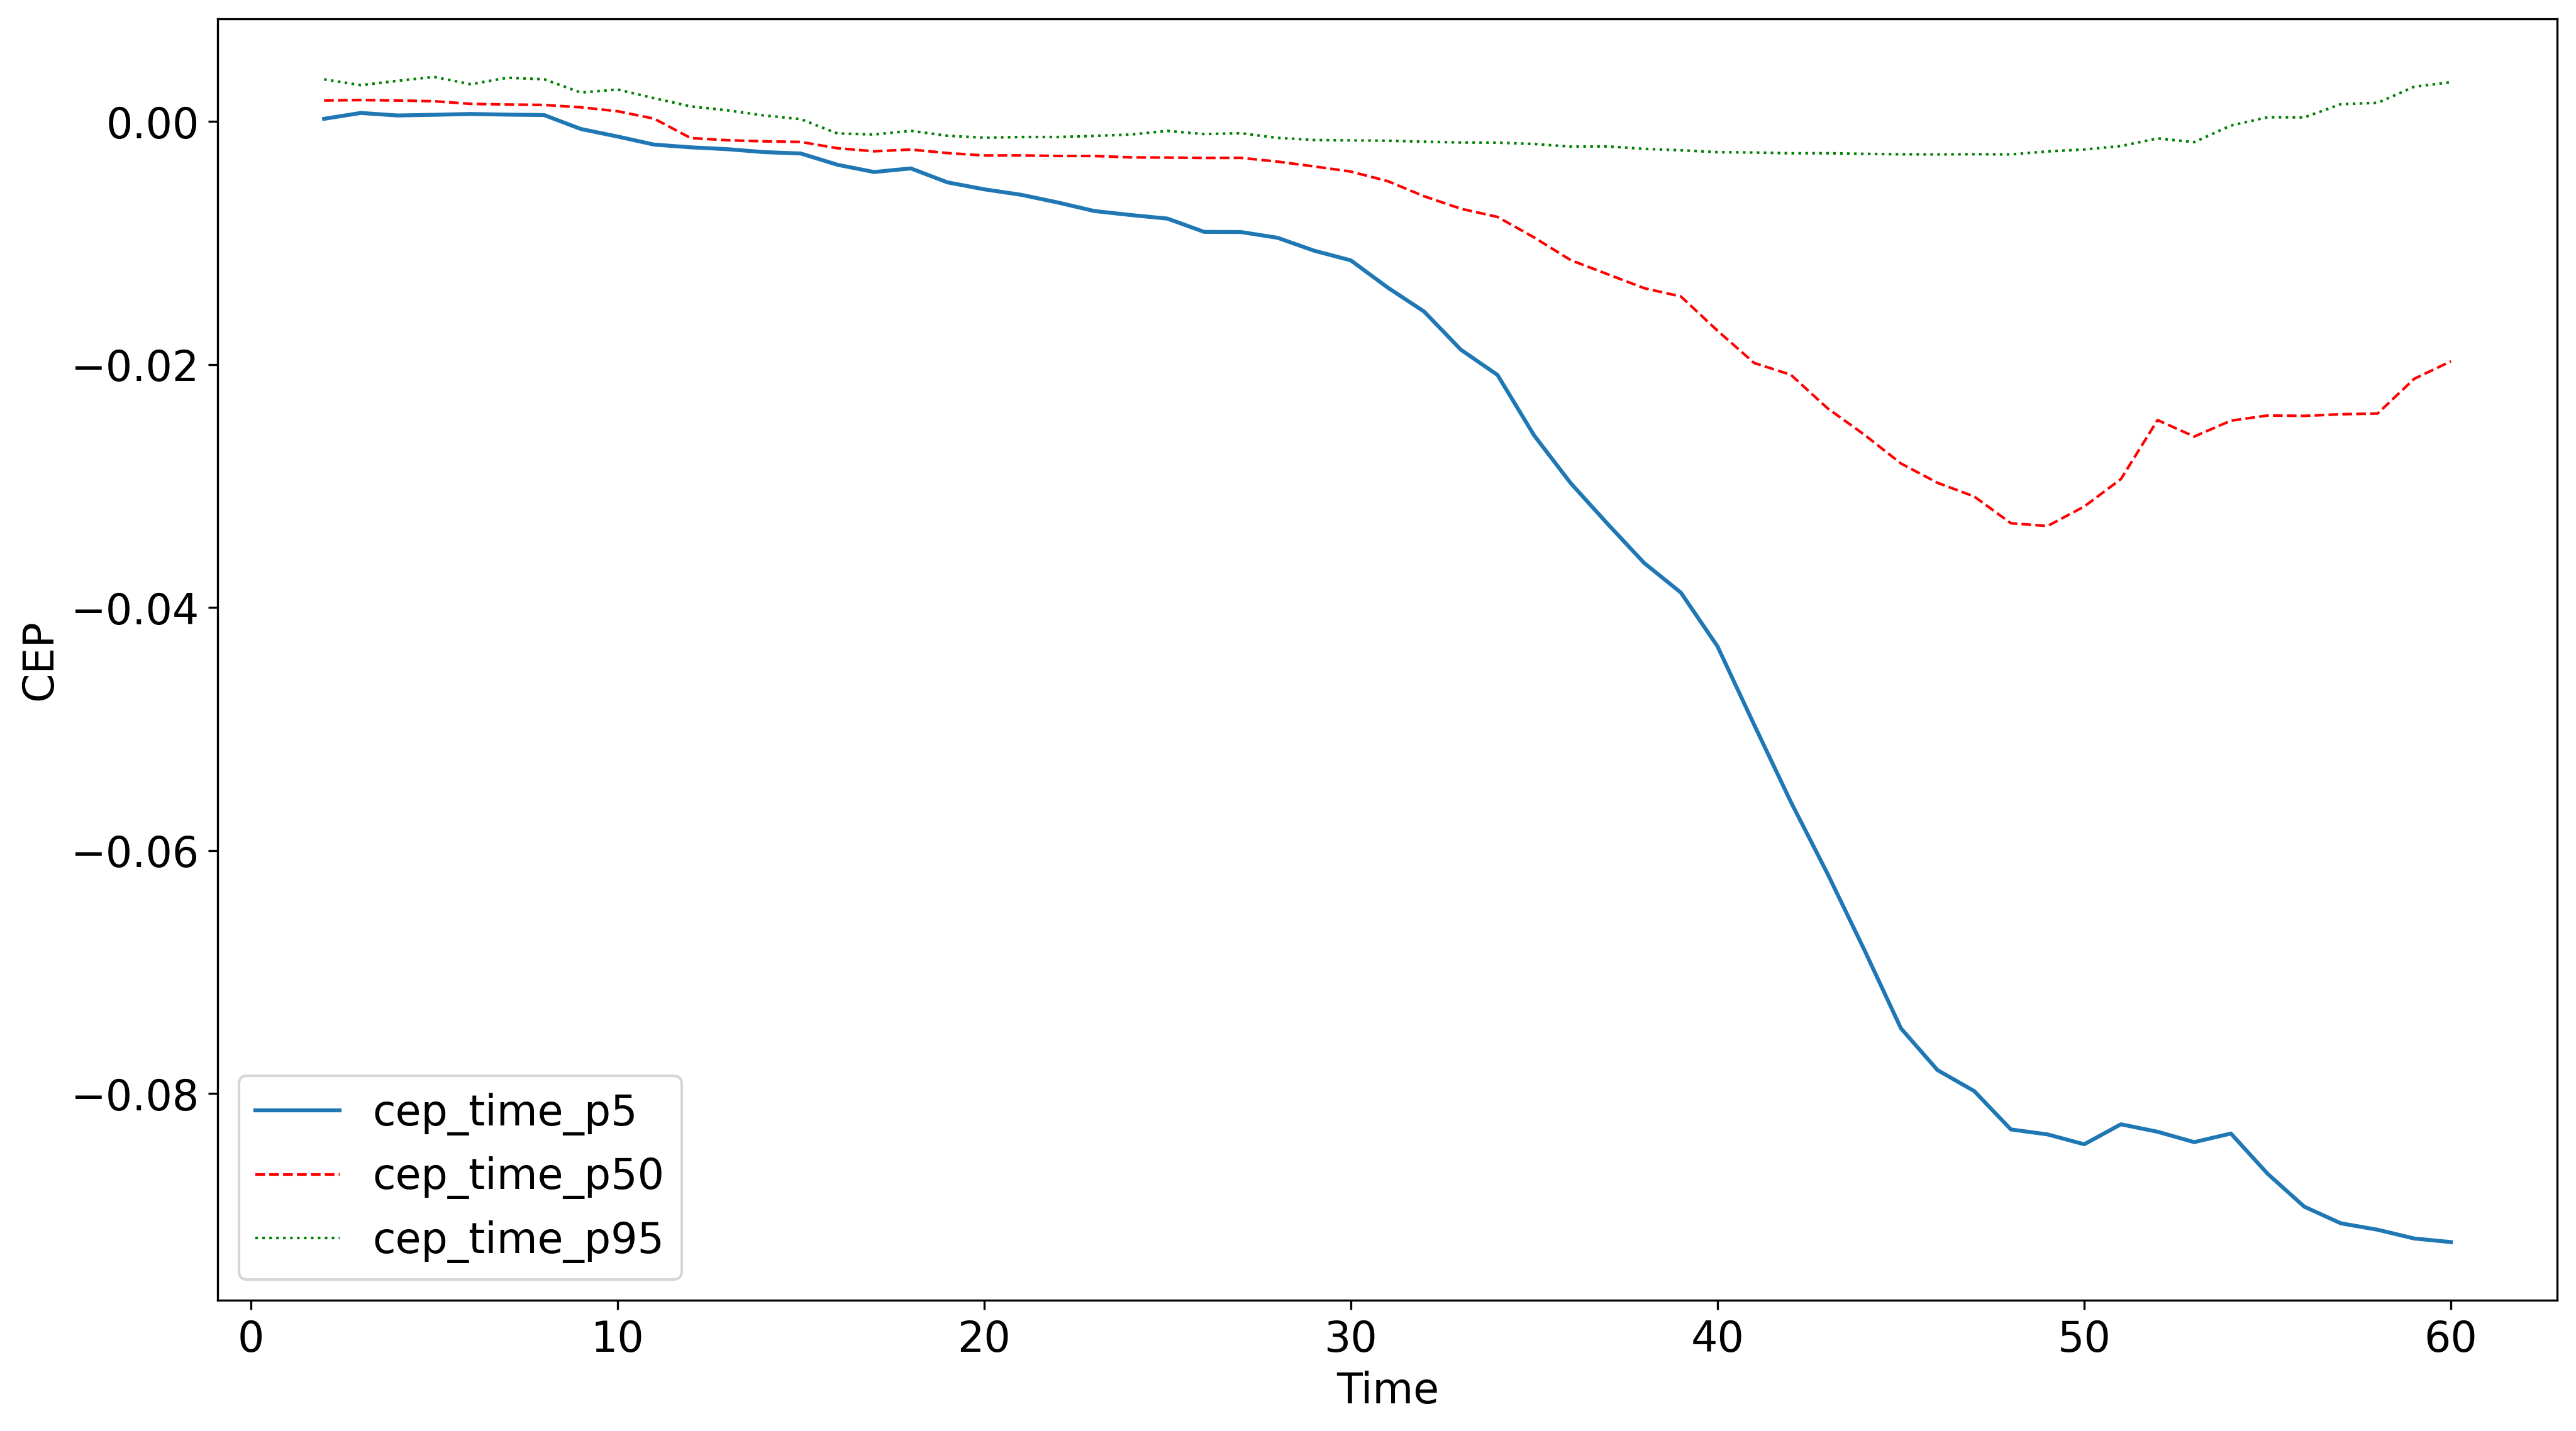

In [94]:
cep_time_p25 = data.groupby('time')['cep_time'].quantile(0.25).reset_index(drop=False)
cep_time_p50 = data.groupby('time')['cep_time'].median().reset_index(drop=False)
cep_time_p75 = data.groupby('time')['cep_time'].quantile(0.75).reset_index(drop=False)

plt.plot('time', 'cep_time', data=cep_time_p25, label='cep_time_p5')
plt.plot('time', 'cep_time', data=cep_time_p50, color='red', linewidth=1, label='cep_time_p50',linestyle='dashed')
plt.plot('time', 'cep_time', data=cep_time_p75, color='green', linewidth=1, label='cep_time_p95',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('CEP')
plt.legend(loc='best')
plt.show()

## Equity

In [95]:
data.loc[:,'equity_time'] = 1-(data.loc[:,'LTV_time']/100)

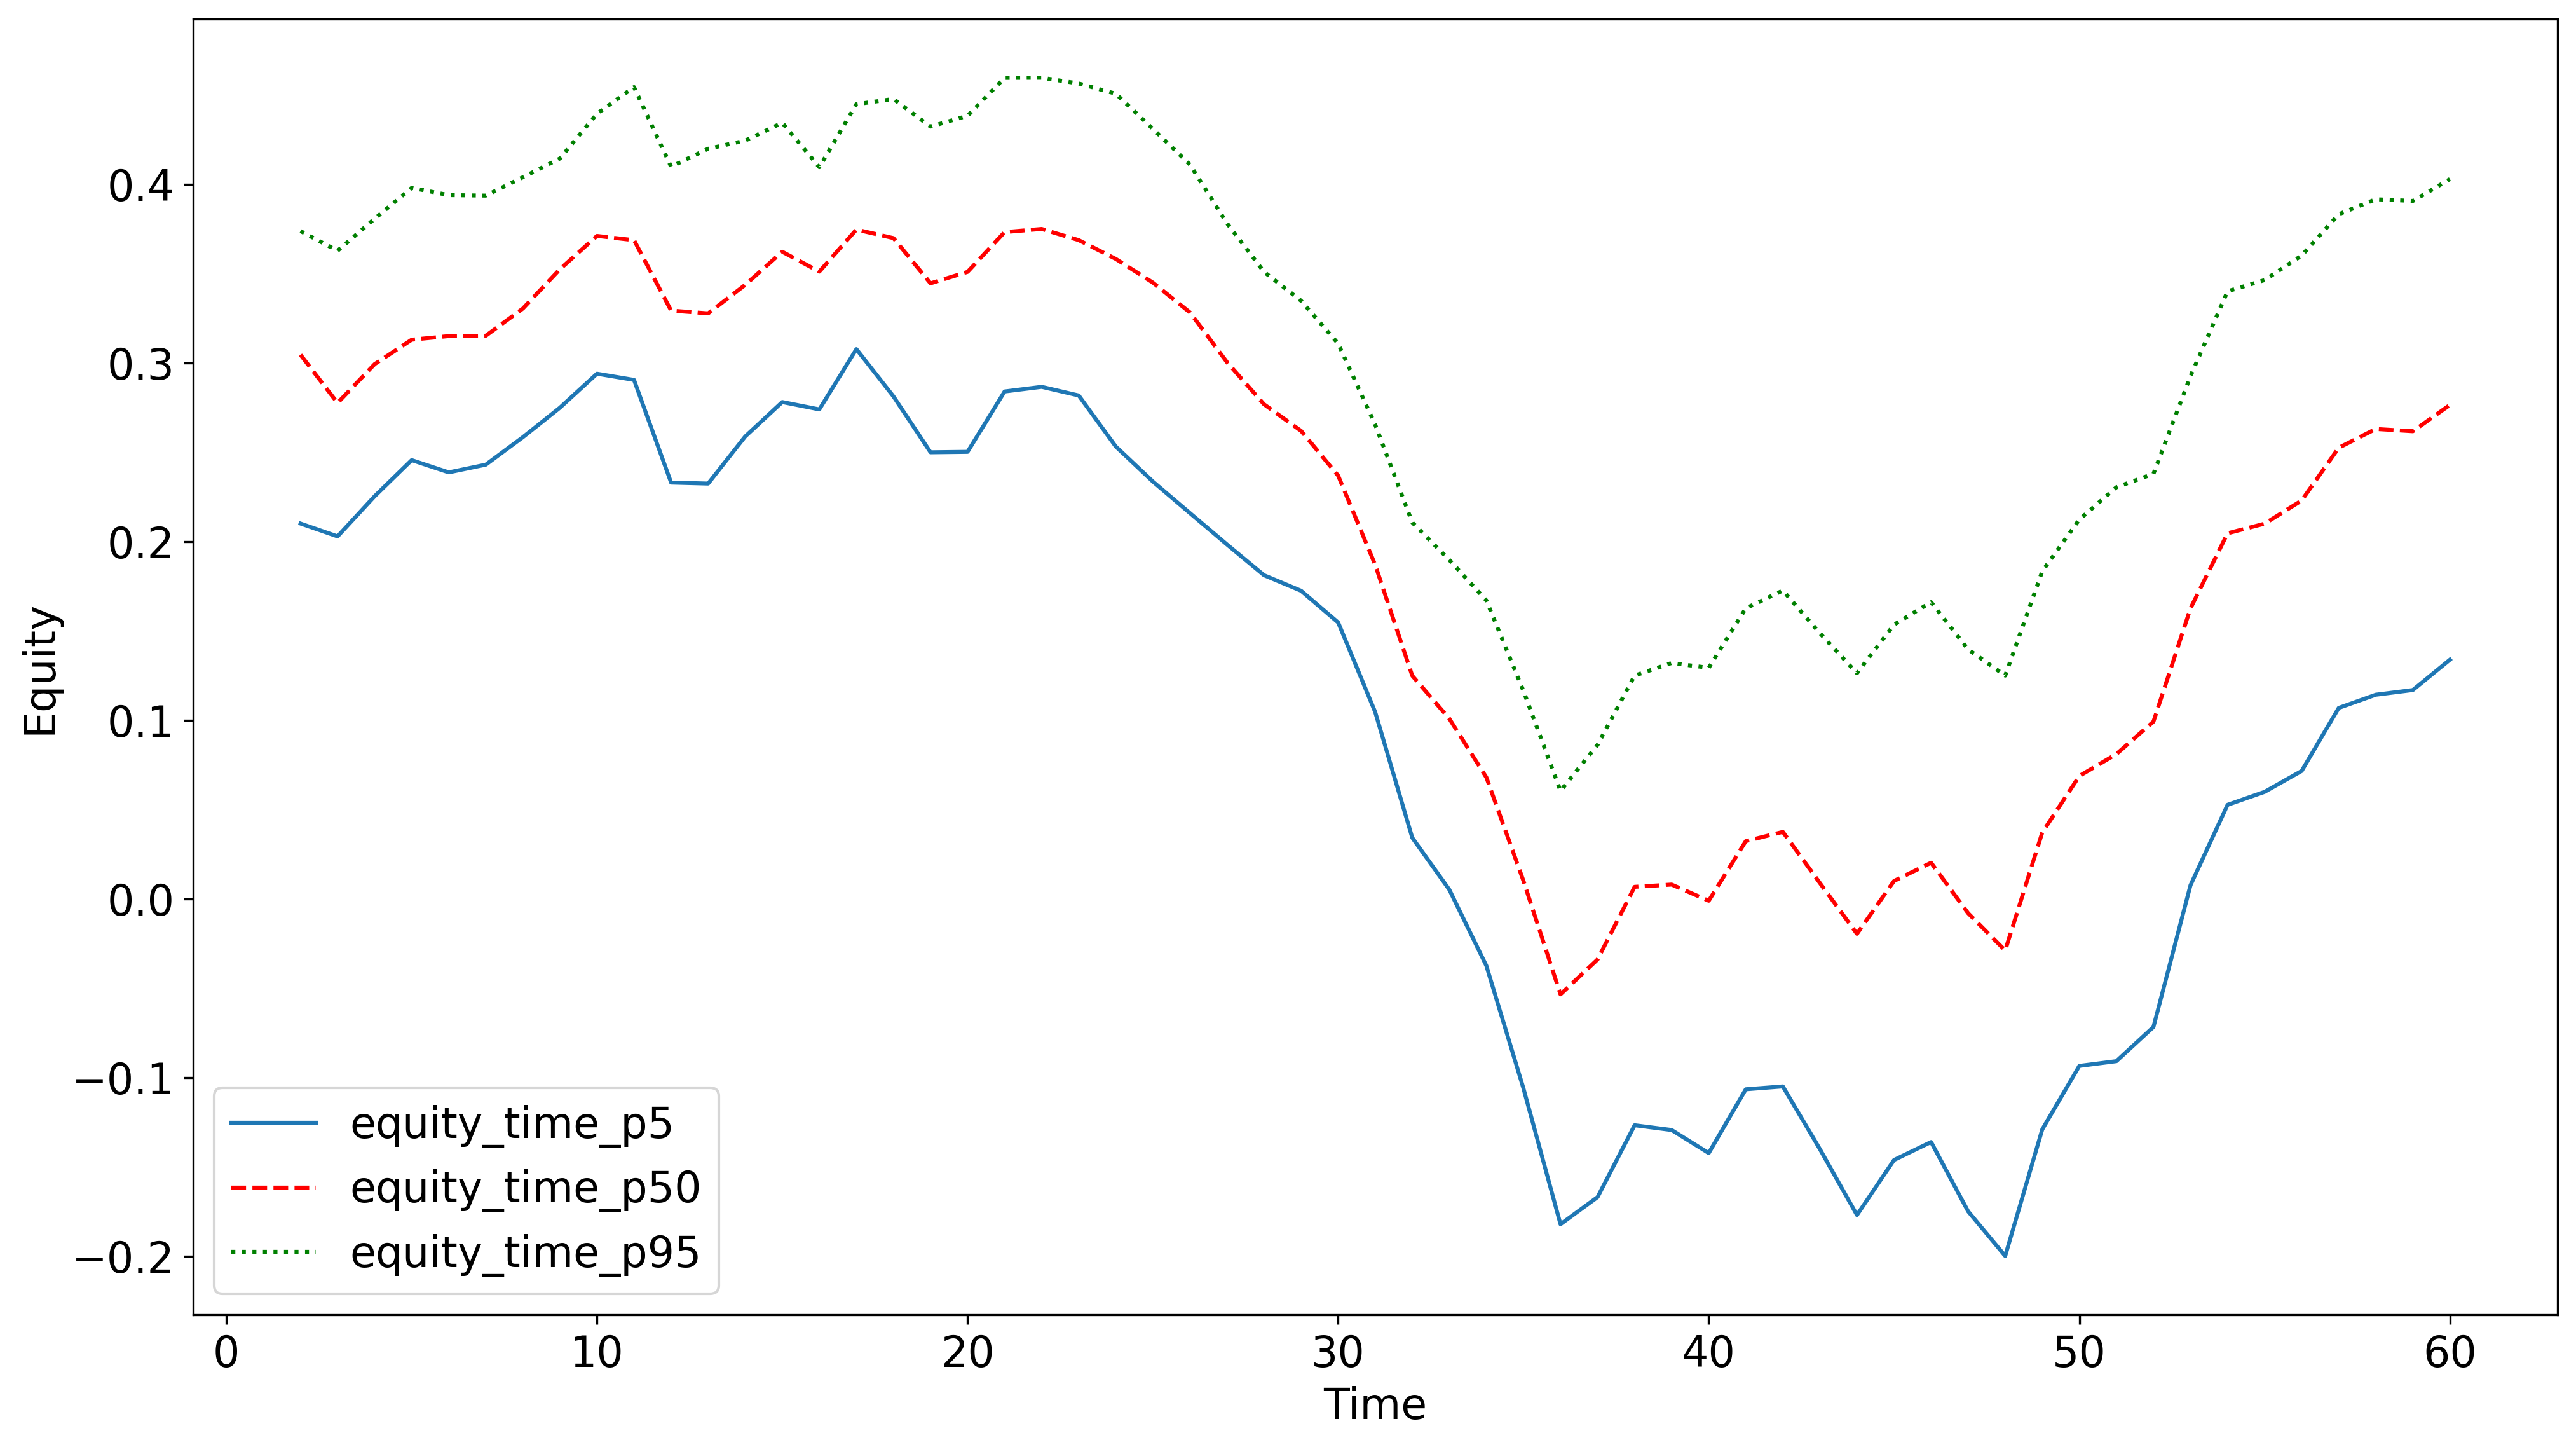

In [96]:
equity_time_p25 = data.groupby('time')['equity_time'].quantile(0.25).reset_index(drop=False)
equity_time_p50 = data.groupby('time')['equity_time'].mean().reset_index(drop=False)
equity_time_p75 = data.groupby('time')['equity_time'].quantile(0.75).reset_index(drop=False)

plt.plot('time', 'equity_time', data=equity_time_p25, label='equity_time_p5')
plt.plot('time', 'equity_time', data=equity_time_p50, color='red', label='equity_time_p50',linestyle='dashed')
plt.plot('time', 'equity_time', data=equity_time_p75, color='green', label='equity_time_p95',linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend(loc='best')
plt.show()

In [97]:
data2=data[['cep_time', 'equity_time']]

print(data2.corr(method='pearson').round(decimals=2))  

             cep_time  equity_time
cep_time         1.00         0.61
equity_time      0.61         1.00


## Example Borrower 9 and 47

In [98]:
data2 = data.loc[(data.id==9)|(data.id==47),['id', 'time', 'default_time', 'cep_time', 'equity_time']].round(decimals=2).copy()

print(data2)

         id  time  default_time  cep_time  equity_time
1       9.0  25.0           0.0     -0.01         0.34
1845    9.0  26.0           0.0     -0.00         0.34
3738    9.0  27.0           0.0     -0.00         0.34
5819    9.0  28.0           0.0      0.00         0.33
8080    9.0  29.0           0.0      0.00         0.32
...     ...   ...           ...       ...          ...
23579   9.0  36.0           0.0     -0.05        -0.00
25316   9.0  37.0           1.0     -0.05         0.01
2      47.0  25.0           0.0     -0.00         0.33
1846   47.0  26.0           0.0     -0.00         0.33
3739   47.0  27.0           0.0     -0.00         0.32

[16 rows x 5 columns]


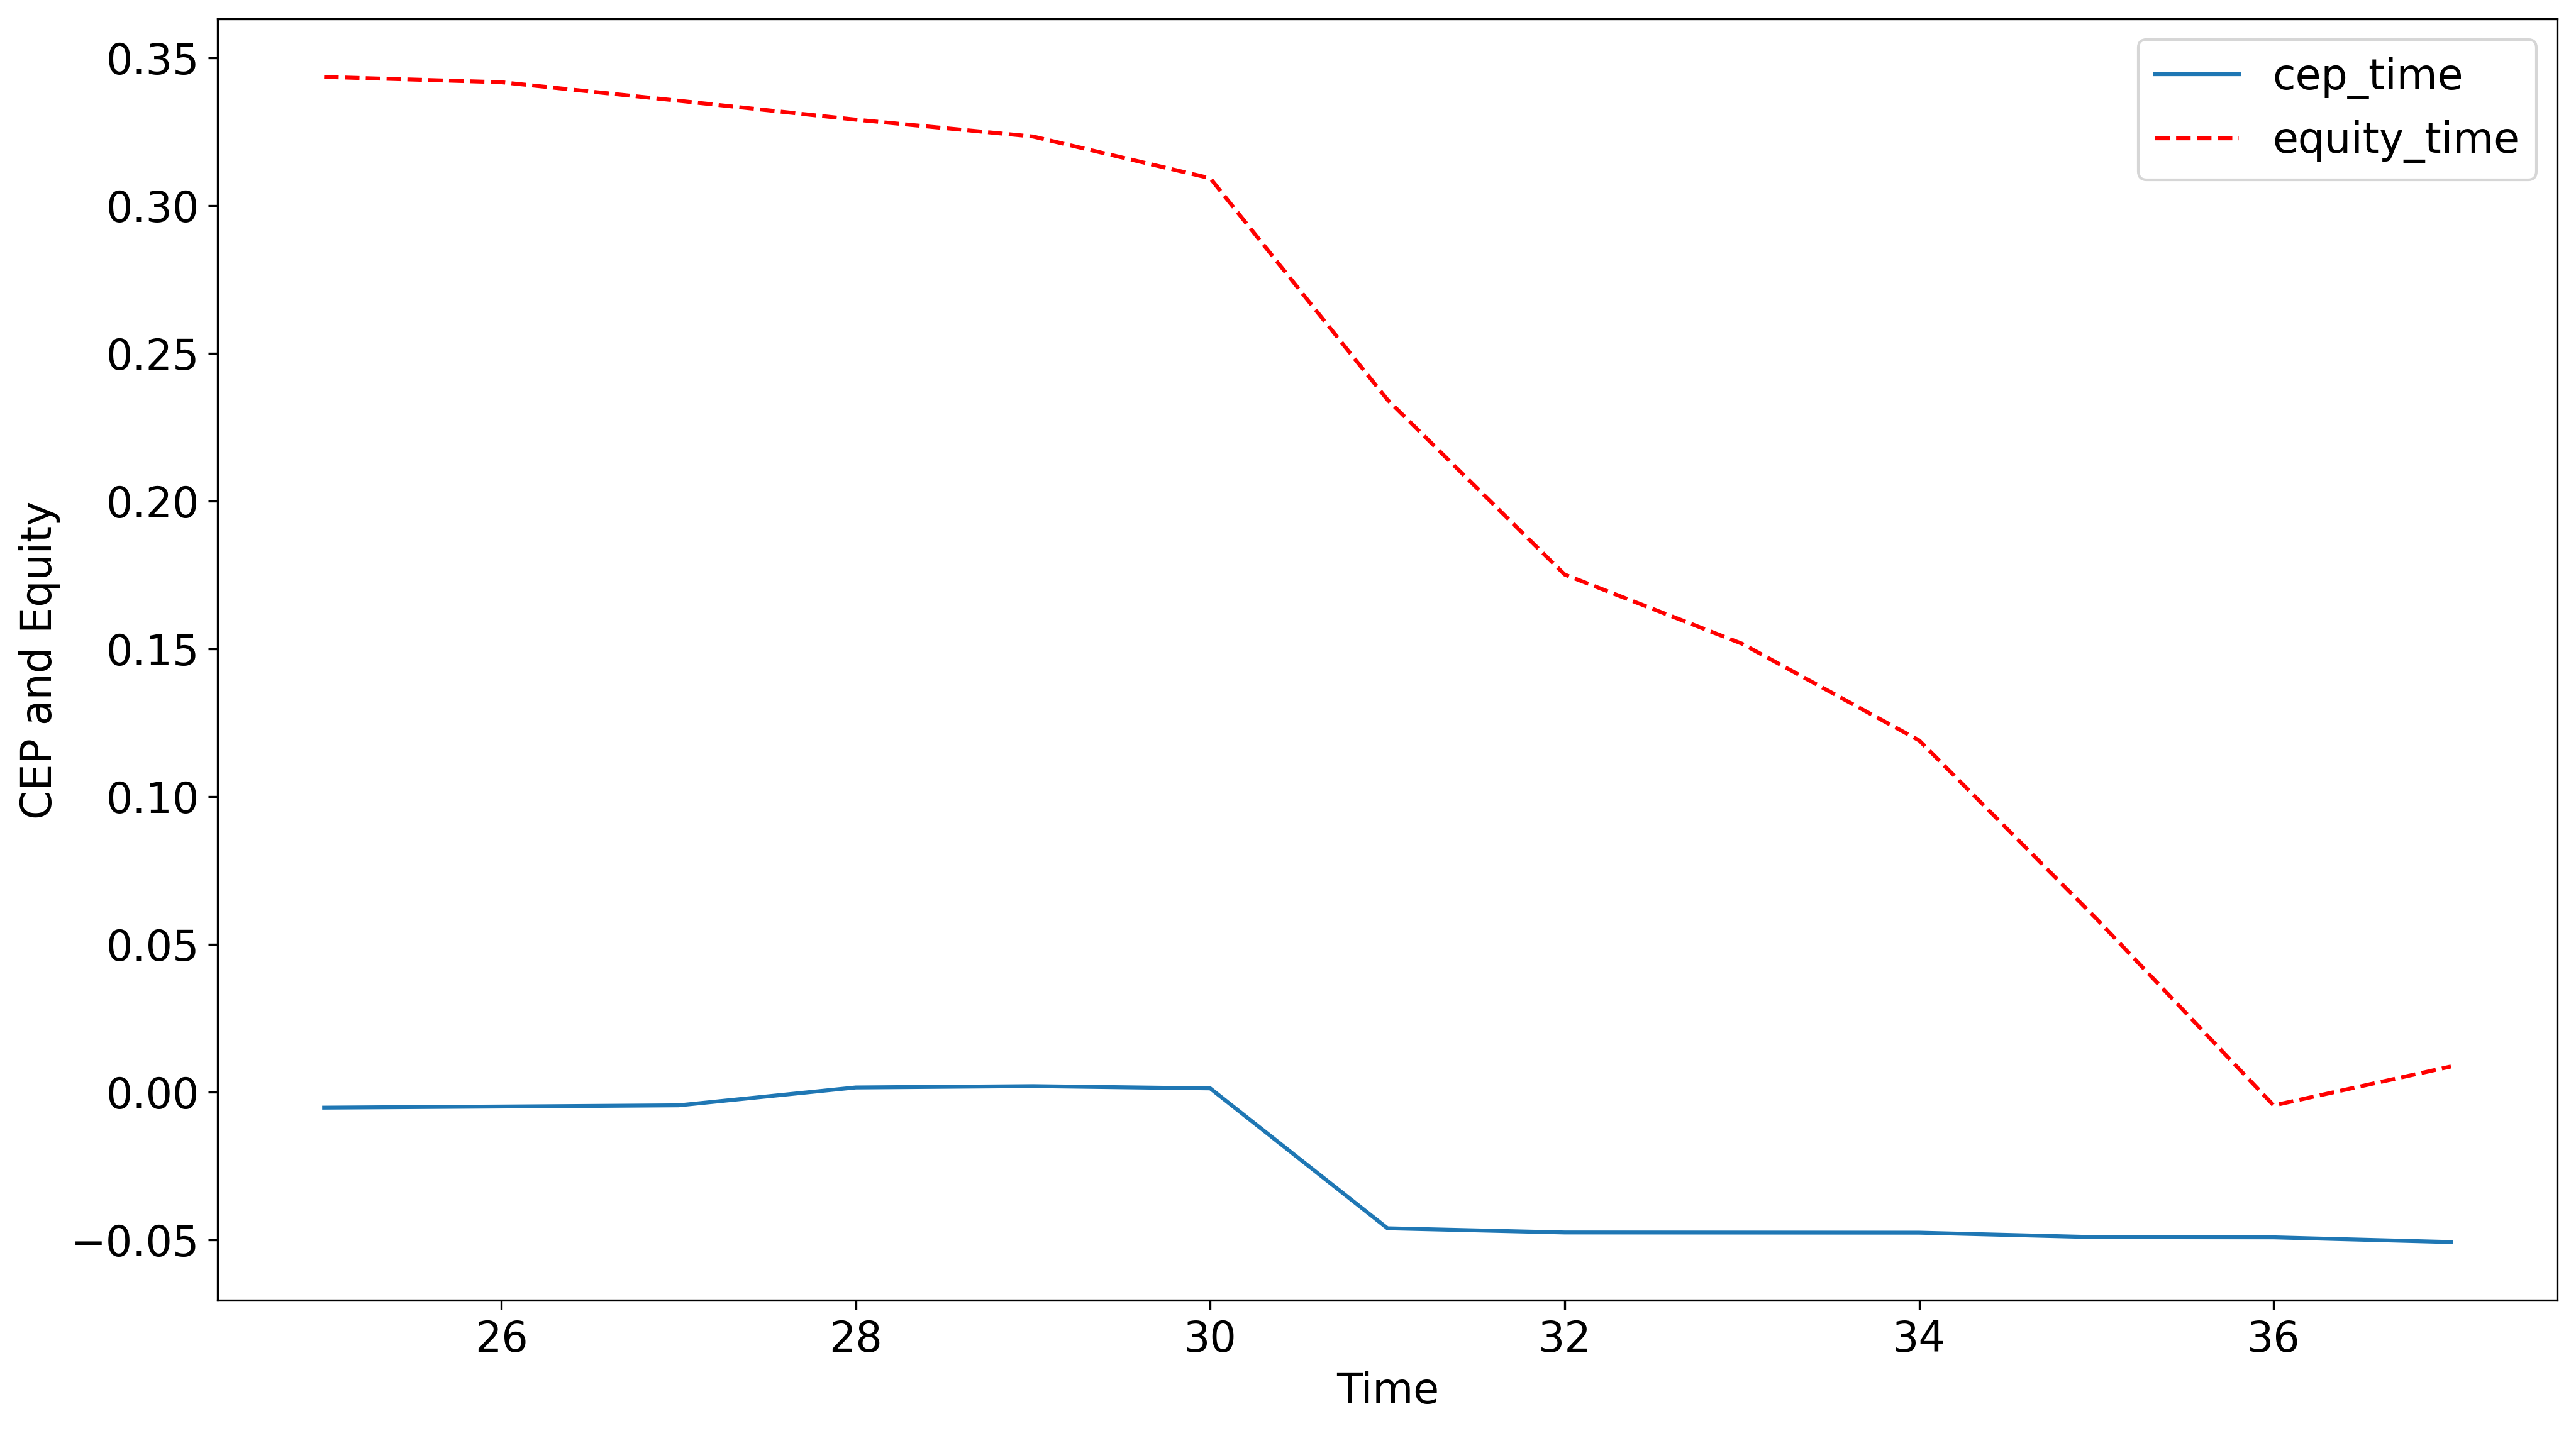

In [99]:
data2=data.loc[(data.id == 9),['time', 'cep_time', 'equity_time']]
               
plt.plot('time', 'cep_time', data=data2, label='cep_time')
plt.plot('time', 'equity_time', data=data2, color='red', label='equity_time',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('CEP and Equity')
plt.legend(loc='best')
plt.show()

## Time, Vintage and Age

In [100]:
data.loc[:,'age'] = data.loc[:,'time']-data.loc[:,'orig_time']
data.loc[data['age'] >= 40, 'age'] = 40
    
data.loc[:, 'vintage'] = data.loc[:,'orig_time']
data.loc[data['vintage'] < 0, 'vintage'] = 0
data.loc[data['vintage'] >= 30, 'vintage'] = 30

### Time

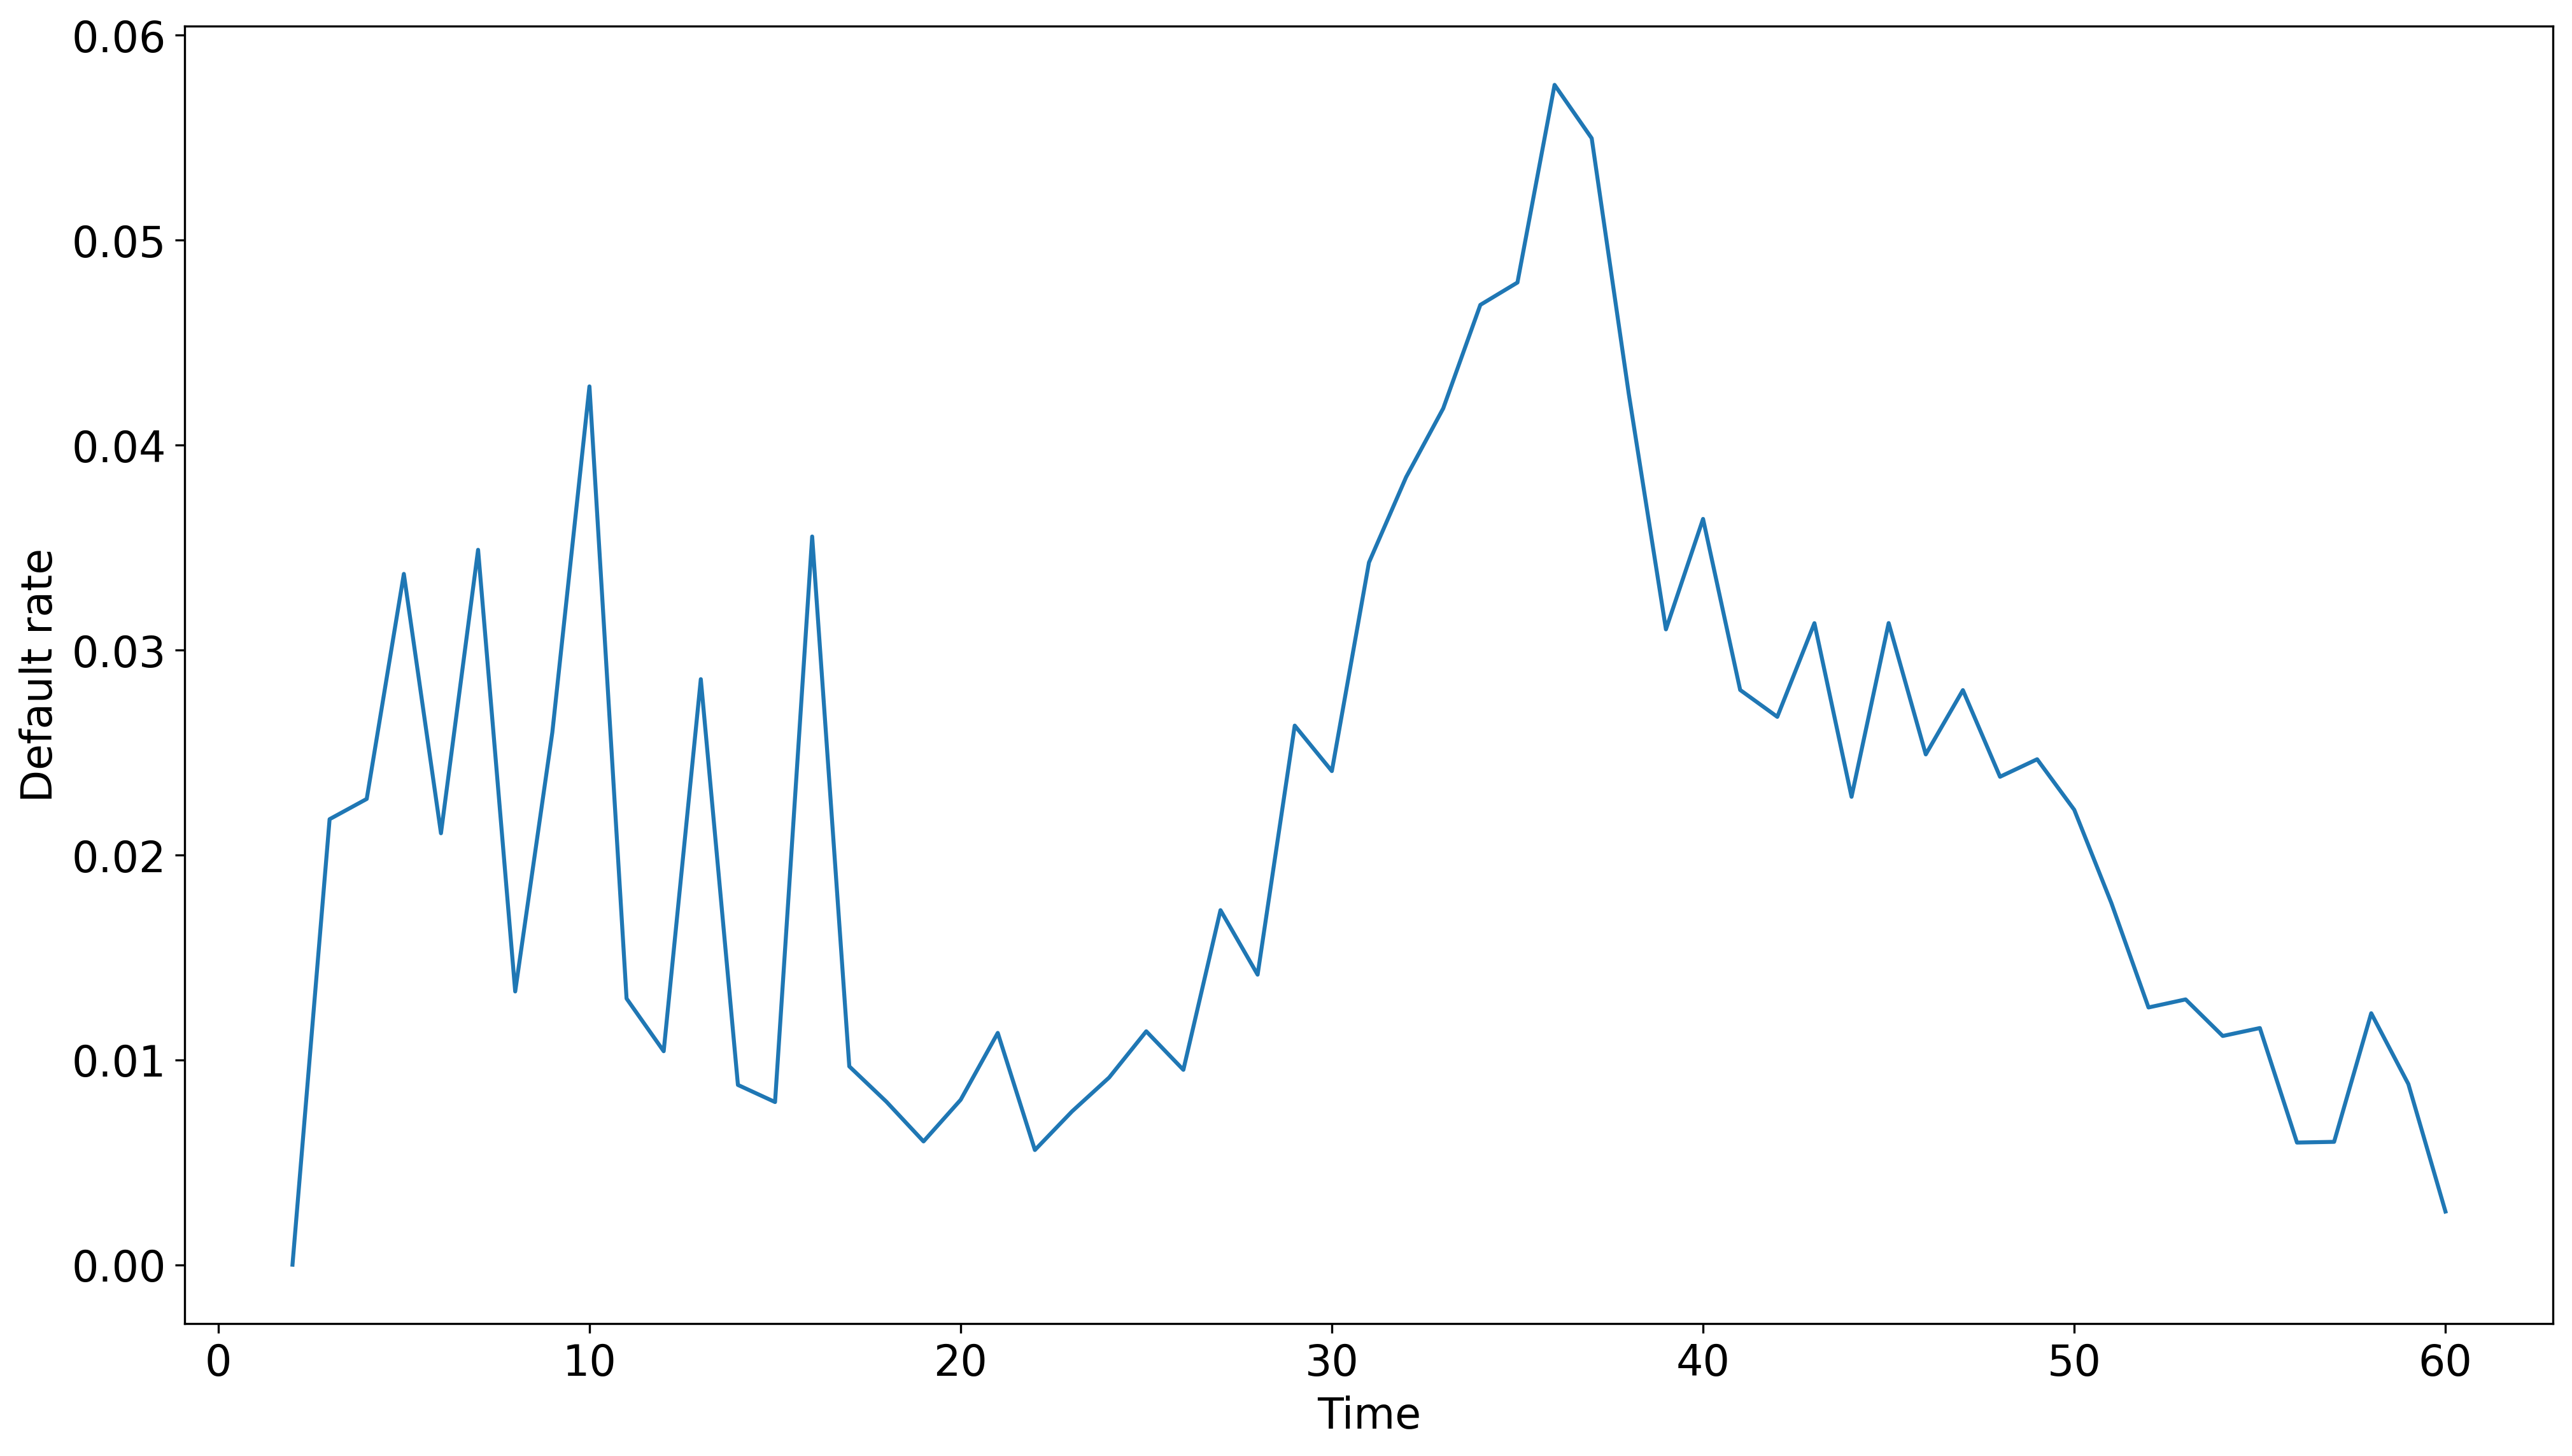

In [101]:
default_rate = data.groupby('time')['default_time'].mean().reset_index(drop=False)

plt.plot('time', 'default_time', data=default_rate)
plt.xlabel('Time')
plt.ylabel('Default rate')
plt.show()

### Vintage

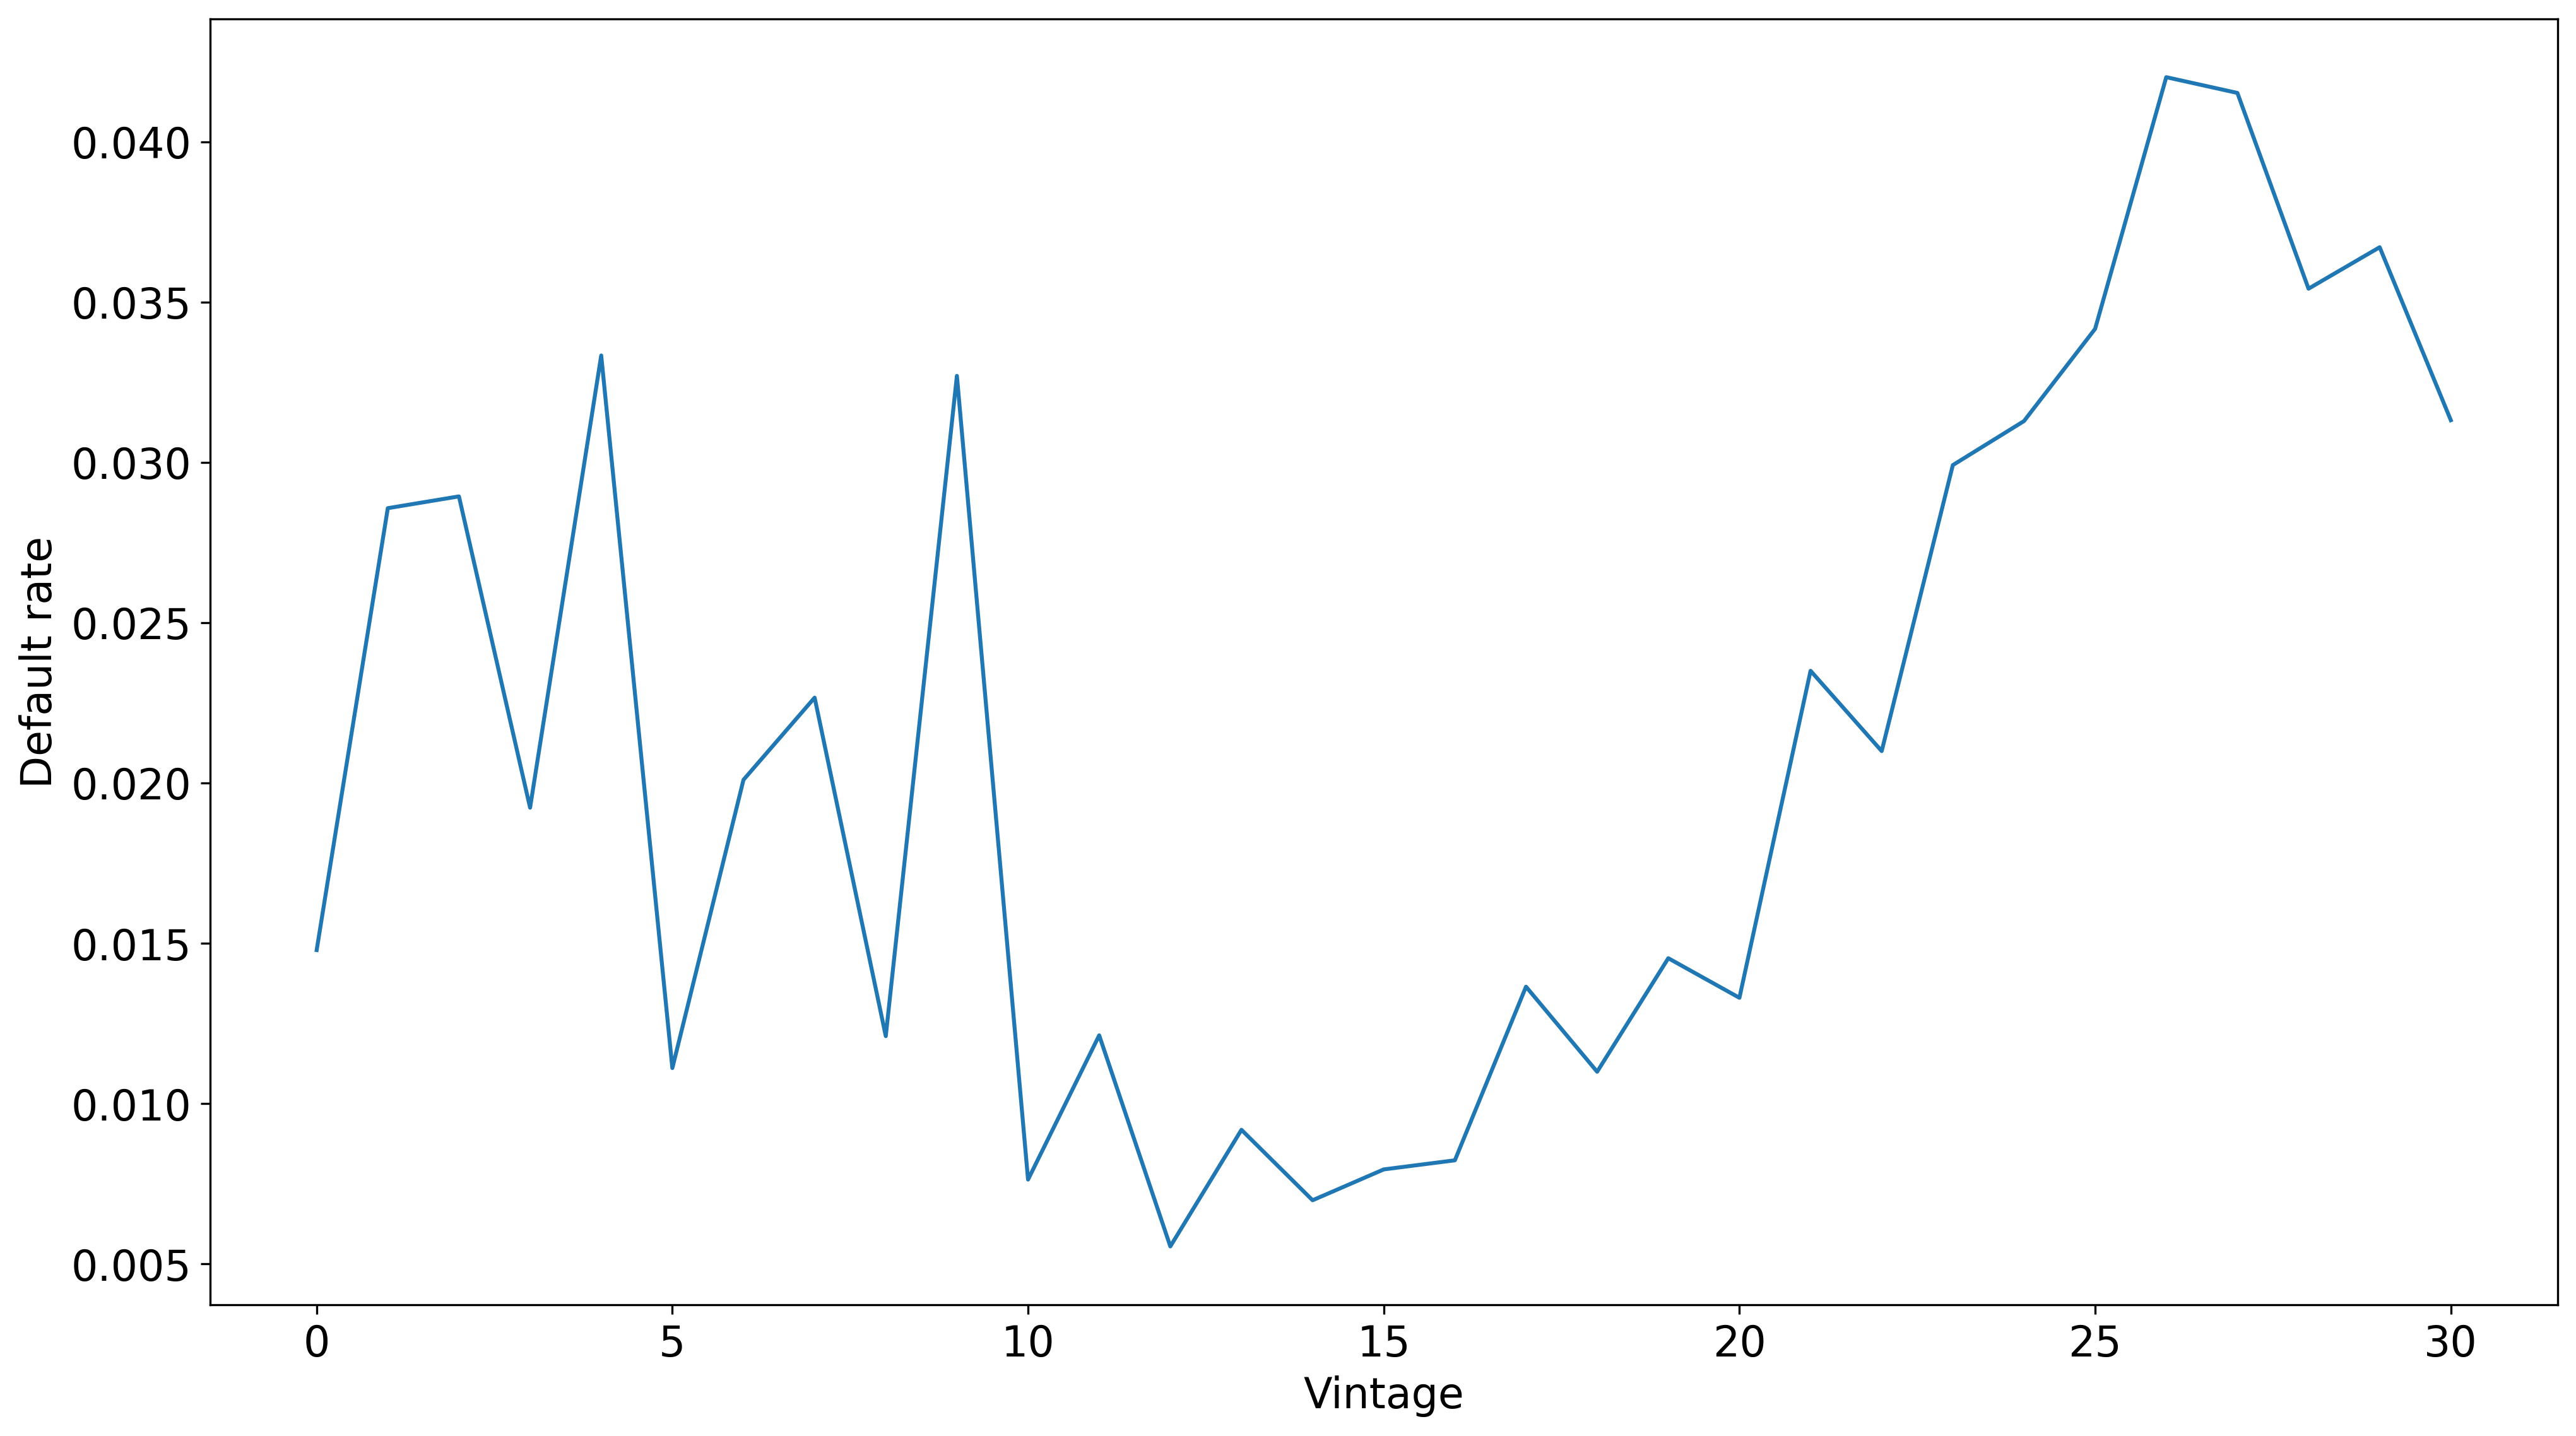

In [102]:
default_rate = data.groupby('vintage')['default_time'].mean().reset_index(drop=False)

plt.plot('vintage', 'default_time', data=default_rate)
plt.xlabel('Vintage')
plt.ylabel('Default rate')
plt.show()

### Age

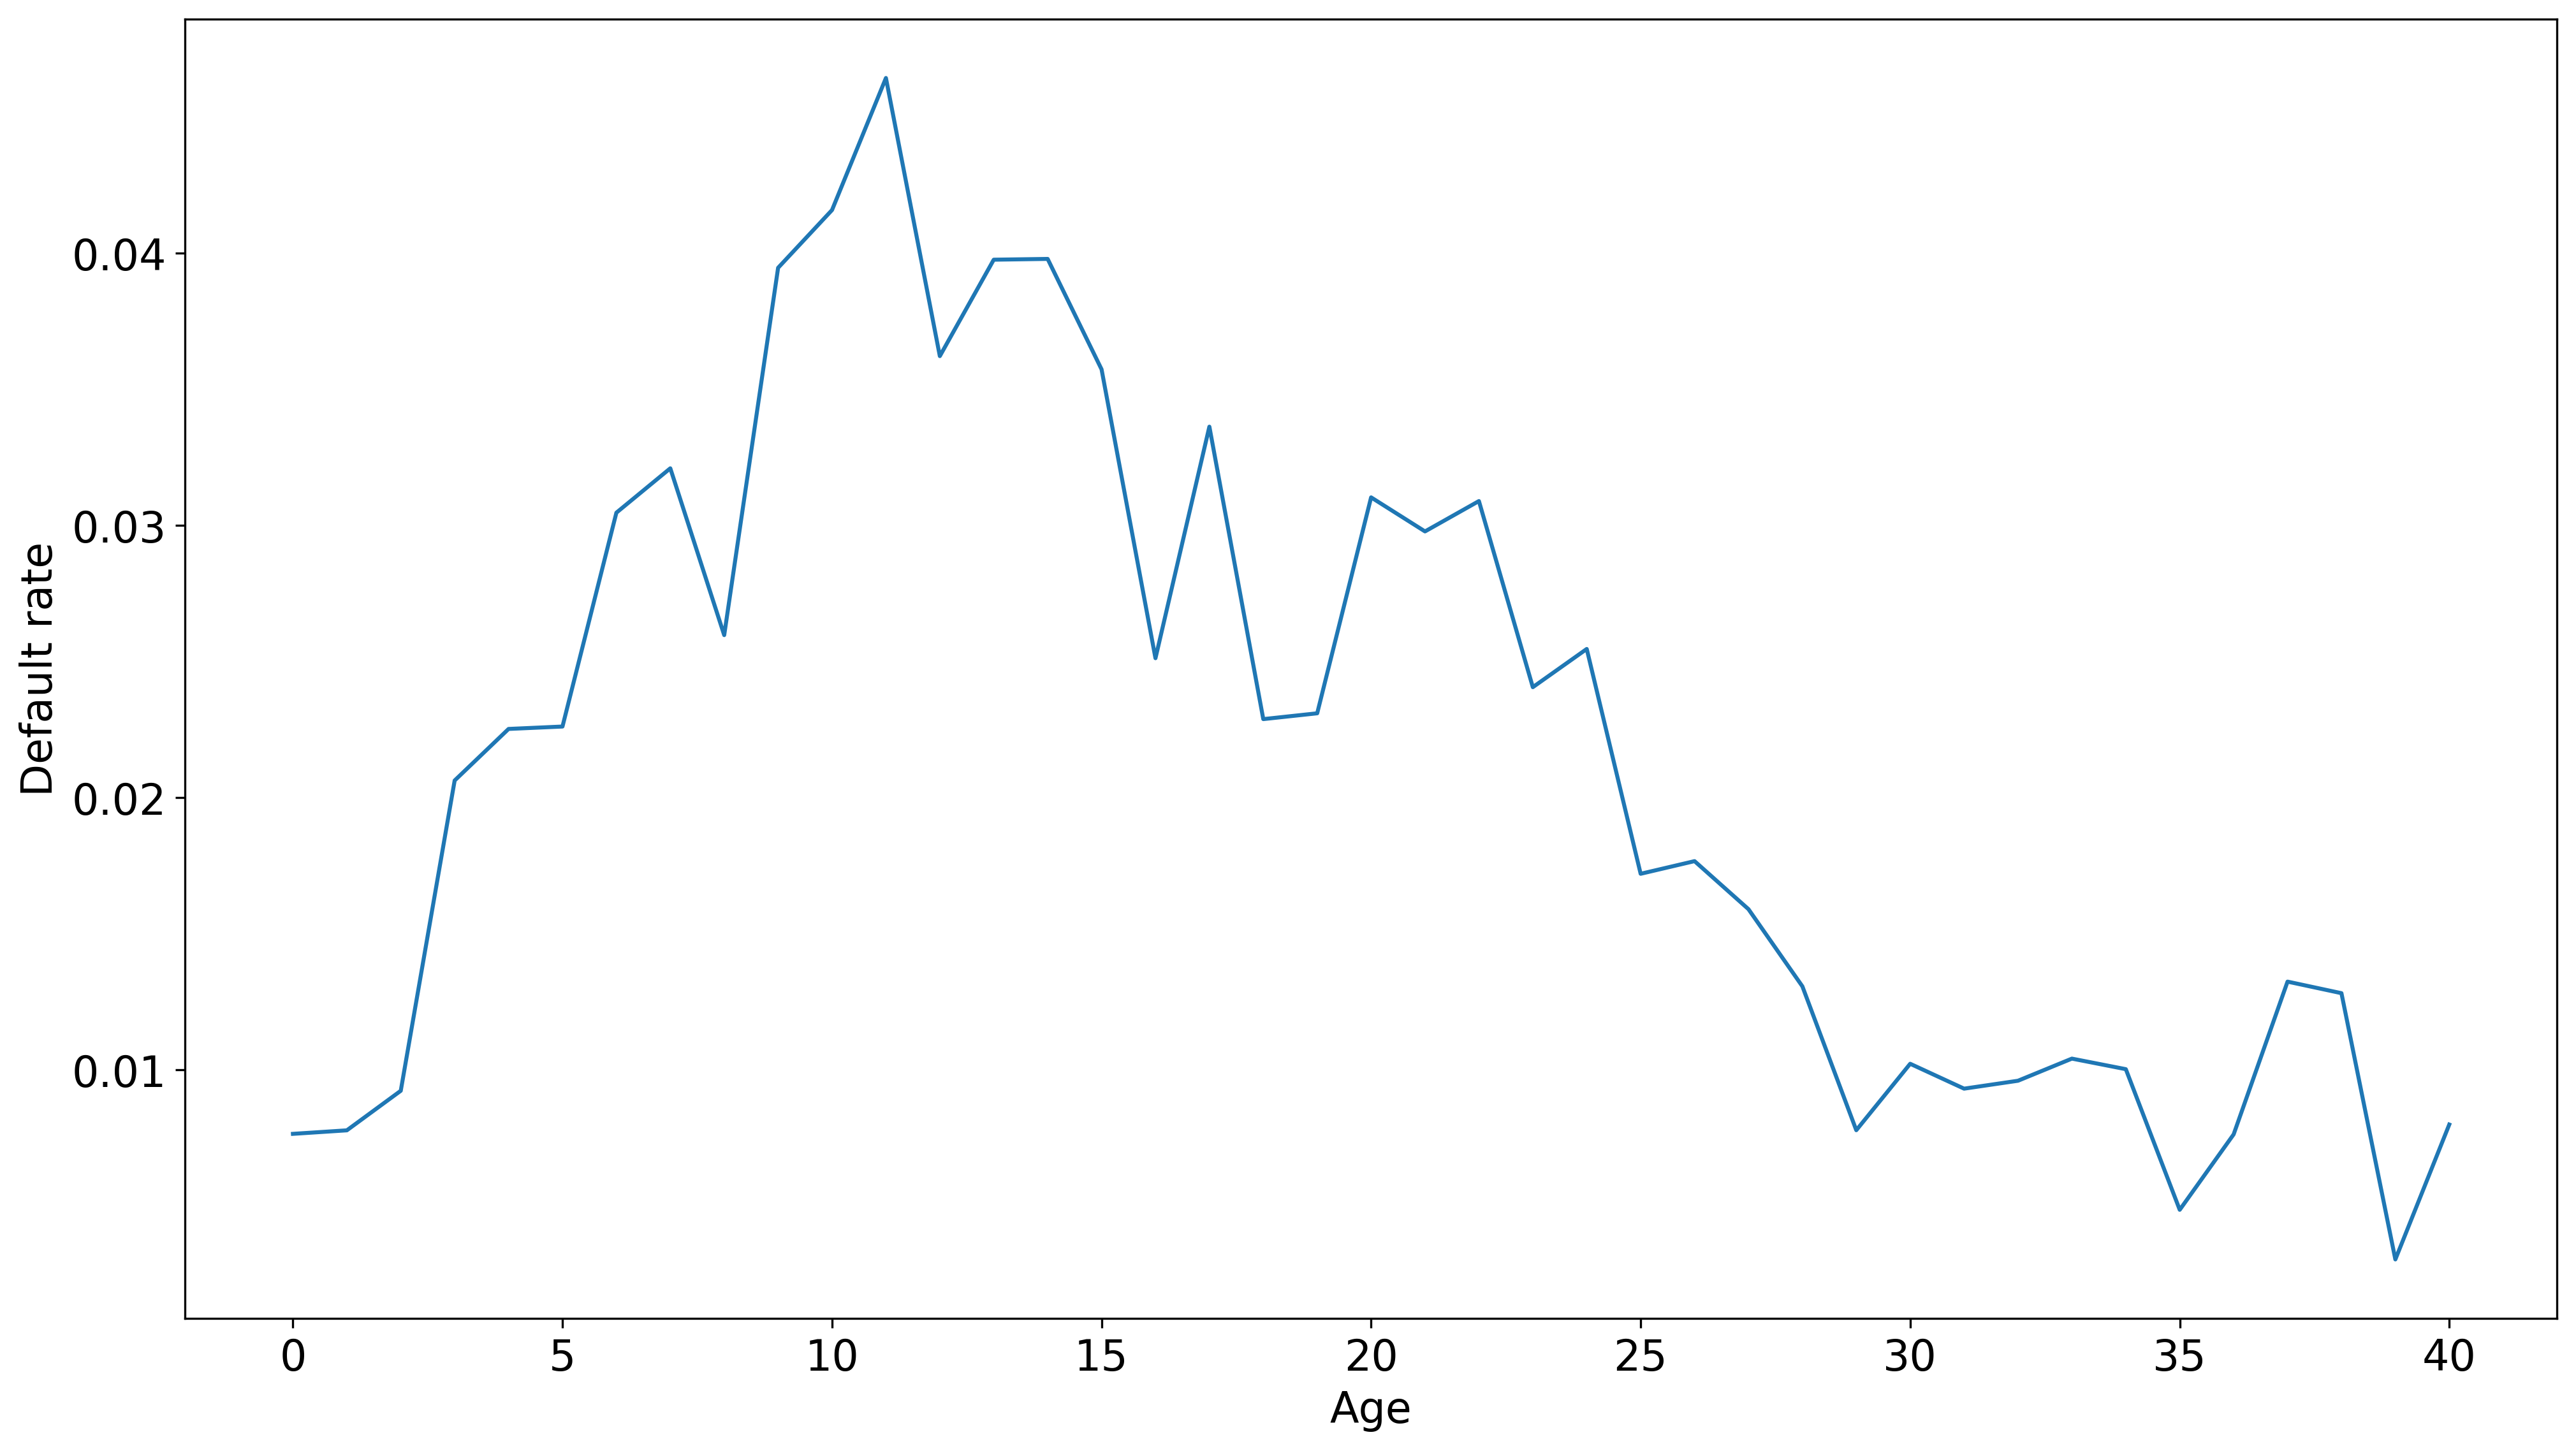

In [103]:
data_mean_age = data.groupby('age')['default_time'].mean().reset_index(drop=False)

plt.plot('age', 'default_time', data=data_mean_age)
plt.xlabel('Age')
plt.ylabel('Default rate')
plt.show()

## Environment

In [104]:
data.loc[:, 'state_orig_time'] = pd.Categorical(data.state_orig_time, ordered=False)

# Univariate Feature Selection

## Means Test

In [105]:
data2 = data[['default_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 
'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'FICO_orig_time', 'LTV_orig_time']].copy()

data2.dropna(inplace=True)
mean = data2.groupby('default_time').mean().transpose()

dt0 = data2.query('default_time == 0')
dt1 = data2.query('default_time == 1')

dt0 = dt0.drop('default_time', axis=1)
dt1 = dt1.drop('default_time', axis=1)

ttest1 = ttest_ind(dt0, dt1, equal_var = True).pvalue
ttest2 = abs(ttest_ind(dt0, dt1, equal_var = True).statistic)

ttest1 = pd.DataFrame(ttest1, columns = ['pValue'])
ttest2 = pd.DataFrame(ttest2, columns = ['tStat'])

new_index= mean.index.tolist()

ttest1.index = new_index
ttest2.index = new_index

print(pd.concat([mean, ttest1, ttest2], axis=1).round(decimals=2).sort_values(by=['tStat'], ascending=False))

                        0.0     1.0  pValue  tStat
LTV_time              83.03   97.75    0.00  19.96
gdp_time               1.41    0.48    0.00  18.02
interest_rate_time     6.60    7.55    0.00  17.35
FICO_orig_time       675.23  650.57    0.00  13.10
hpi_time             184.45  175.69    0.00  11.98
LTV_orig_time         78.44   81.00    0.00   9.54
uer_time               6.49    6.89    0.00   7.76
REtype_CO_orig_time    0.06    0.05    0.18   1.33
REtype_PU_orig_time    0.13    0.14    0.69   0.40


## F-Statistic

In [106]:
data2=data[['default_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'FICO_orig_time', 'LTV_orig_time']].dropna()

X = data2[['LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'FICO_orig_time', 'LTV_orig_time']].values

y = data2[['default_time']].values.reshape(-1,)

transformer1 = f_classif(X, y)

print('F-statistics and p-values:') 
print(np.round(transformer1,1)) 

transformer2 =  SelectKBest(f_classif, k=5)
X2 = transformer2.fit_transform(X, y)

print('5 best variables:') 
print(transformer2.get_support()) 

F-statistics and p-values:
[[3.982e+02 3.011e+02 1.435e+02 3.246e+02 6.020e+01 1.800e+00 2.000e-01
  1.716e+02 9.090e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-01 7.000e-01
  0.000e+00 0.000e+00]]
5 best variables:
[ True  True  True  True False False False  True False]


## Association

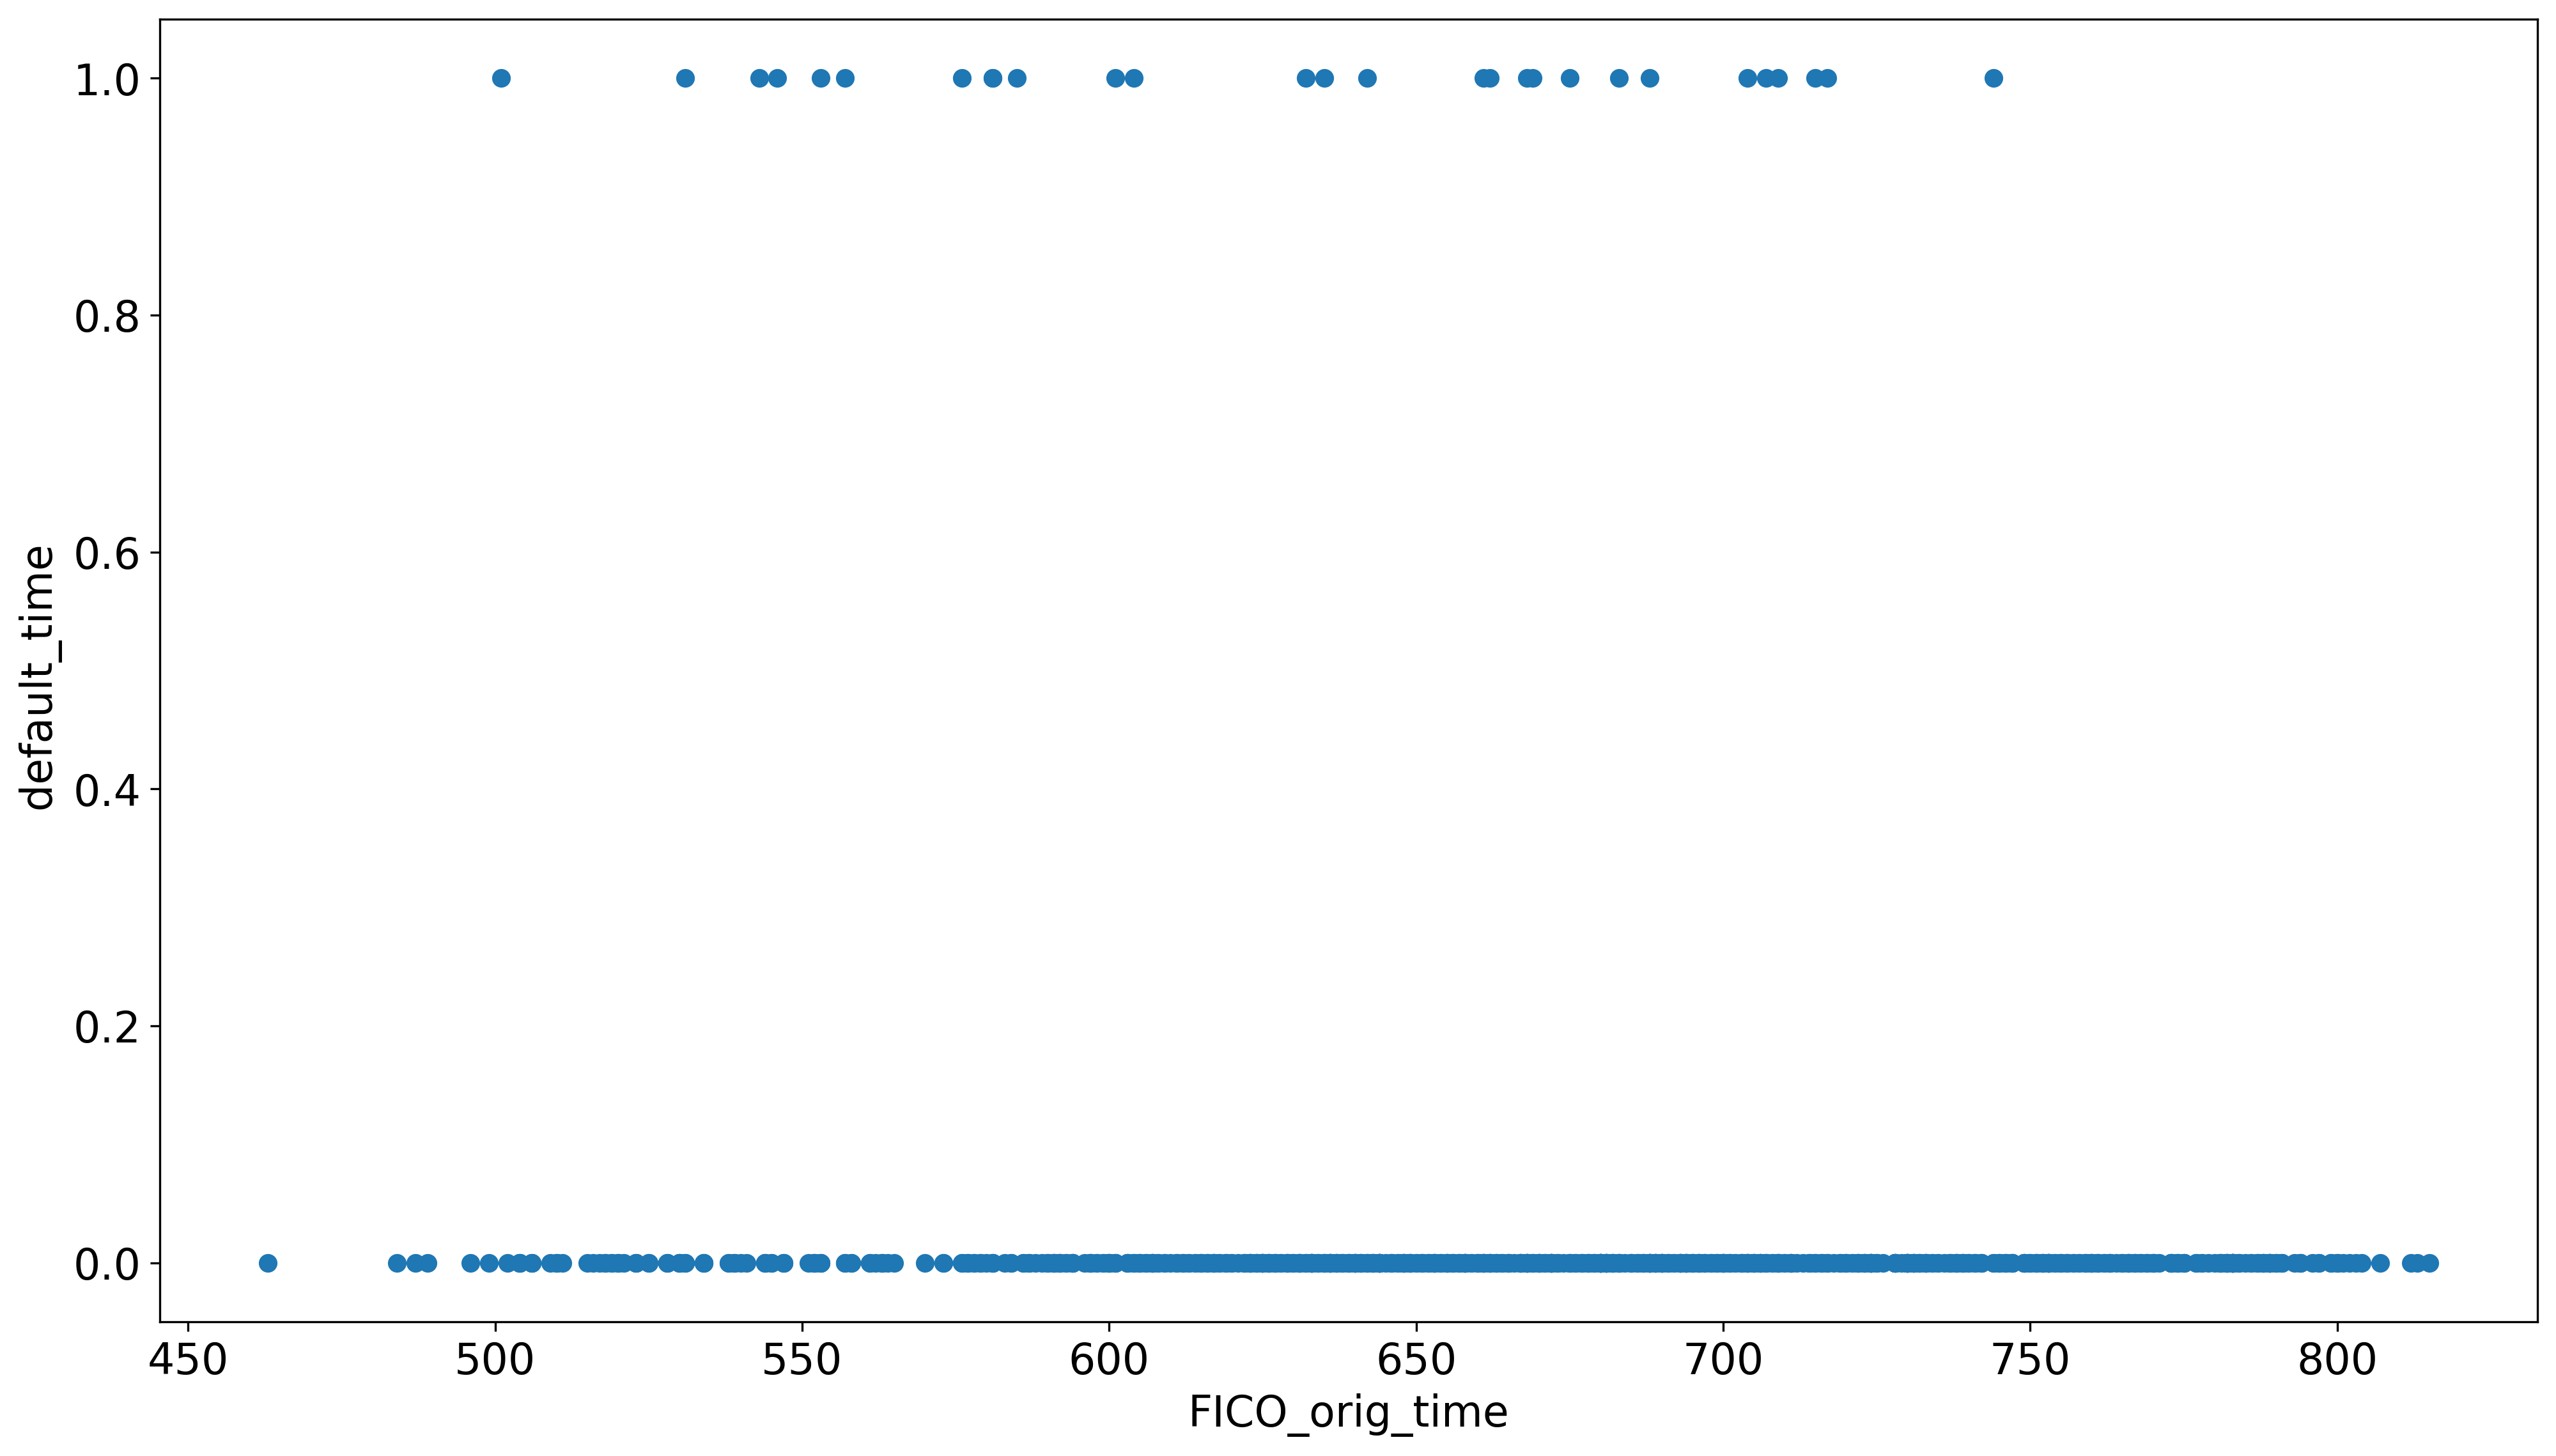

In [107]:
data2 = data.sample(1000, random_state=12345)
data2 = data2[['default_time', 'FICO_orig_time']]

plt.scatter('FICO_orig_time', 'default_time', data=data2)
plt.xlabel('FICO_orig_time')
plt.ylabel('default_time ')
plt.show()

In [108]:
print(data2.corr(method='pearson').round(decimals=2))

                default_time  FICO_orig_time
default_time             1.0            -0.1
FICO_orig_time          -0.1             1.0


## WOE Correlations and Information Value

WOE per class for every variable:
\begin{align*}
WOE_k=ln(\frac{\% \text{defaults}_k}{\% \text{nondefaults}_k})
\end{align*}

Information value per class for a feature:
\begin{align*}
IV_k=(\% \text{defaults}_k-\% \text{nondefaults}_k)*WOE_k
\end{align*}

Sum the **information values** per feature over all classes:
\begin{align*}
IV=\sum_{k=0}^K (IV_k)
\end{align*}


In [109]:
data2, outputIV1 = woe(data_in=data, target='default_time', variable='LTV_time', bins=10, binning='True')
data2, outputIV2 = woe(data_in=data2, target='default_time', variable='interest_rate_time', bins=10, binning='True')
data2, outputIV3 = woe(data_in=data2, target='default_time', variable='FICO_orig_time', bins=10, binning='True')
data2, outputIV4 = woe(data_in=data2, target='default_time', variable='hpi_time', bins=5, binning='True')
data2, outputIV5 = woe(data_in=data2, target='default_time', variable='gdp_time', bins=5, binning='True')
data2, outputIV6 = woe(data_in=data2, target='default_time', variable='uer_time', bins=5, binning='True')
data2, outputIV7 = woe(data_in=data2, target='default_time', variable='LTV_orig_time', bins=5, binning='True')
data2, outputIV8 = woe(data_in=data2, target='default_time', variable='REtype_CO_orig_time', bins=0, binning='False')
data2, outputIV9 = woe(data_in=data2, target='default_time', variable='REtype_PU_orig_time', bins=0, binning='False')

In [110]:
print(pd.concat([outputIV1, outputIV2, outputIV3, outputIV4, outputIV5, outputIV6, outputIV7, outputIV8, outputIV9]).round(decimals=2))

                  name    IV
0             LTV_time  0.47
0   interest_rate_time  0.31
0       FICO_orig_time  0.16
0             hpi_time  0.12
0             gdp_time  0.22
0             uer_time  0.04
0        LTV_orig_time  0.07
0  REtype_CO_orig_time  0.00
0  REtype_PU_orig_time  0.00


Interpretation of IV:

 - Less than 0.02: IV is too low for selection
 - Between 0.02 and 0.1: IV weak
 - Between 0.1 and 0.3: IV moderate
 - Over 0.3: IV strong support for selection


In [111]:
data3 = data2[['LTV_time_WOE', 'interest_rate_time_WOE', 'hpi_time_WOE', 'gdp_time_WOE', 'uer_time_WOE', 'FICO_orig_time_WOE', 'LTV_orig_time_WOE']]

print(data3.corr(method='pearson').round(decimals=2))

                        LTV_time_WOE  interest_rate_time_WOE  hpi_time_WOE  \
LTV_time_WOE                    1.00                    0.09          0.49   
interest_rate_time_WOE          0.09                    1.00         -0.02   
hpi_time_WOE                    0.49                   -0.02          1.00   
gdp_time_WOE                    0.41                    0.09          0.43   
uer_time_WOE                    0.42                   -0.12          0.72   
FICO_orig_time_WOE              0.01                    0.40         -0.02   
LTV_orig_time_WOE               0.36                    0.17         -0.03   

                        gdp_time_WOE  uer_time_WOE  FICO_orig_time_WOE  \
LTV_time_WOE                    0.41          0.42                0.01   
interest_rate_time_WOE          0.09         -0.12                0.40   
hpi_time_WOE                    0.43          0.72               -0.02   
gdp_time_WOE                    1.00          0.21               -0.03   
uer_t

# Default Models

## Link Function

 - Linear link: PDs from minus to plus infinity
\begin{align*}
PD_{it}=P(D_{it}=1|x_{it-1})=\beta_0+\beta_1*\text{feature}_{it-1}
\end{align*}
 - Non-linear link: PDs from zero and one
  - Cumulative logistic distribution: **Logit model**
\begin{align*}
PD_{it}=P(D_{it}=1|x_{it-1})=\frac{exp(\beta_0+\beta_1*\text{feature}_{it-1})}{1+exp(\beta_0+\beta_1*\text{feature}_{it-1})}
\end{align*}
  - Cumulative standard-normal distribution **Probit model**
\begin{align*}
PD_{it}=P(D_{it}=1|x_{it-1})=\Phi(\beta_0+\beta_1*\text{feature}_{it-1})
\end{align*}


## Comparison

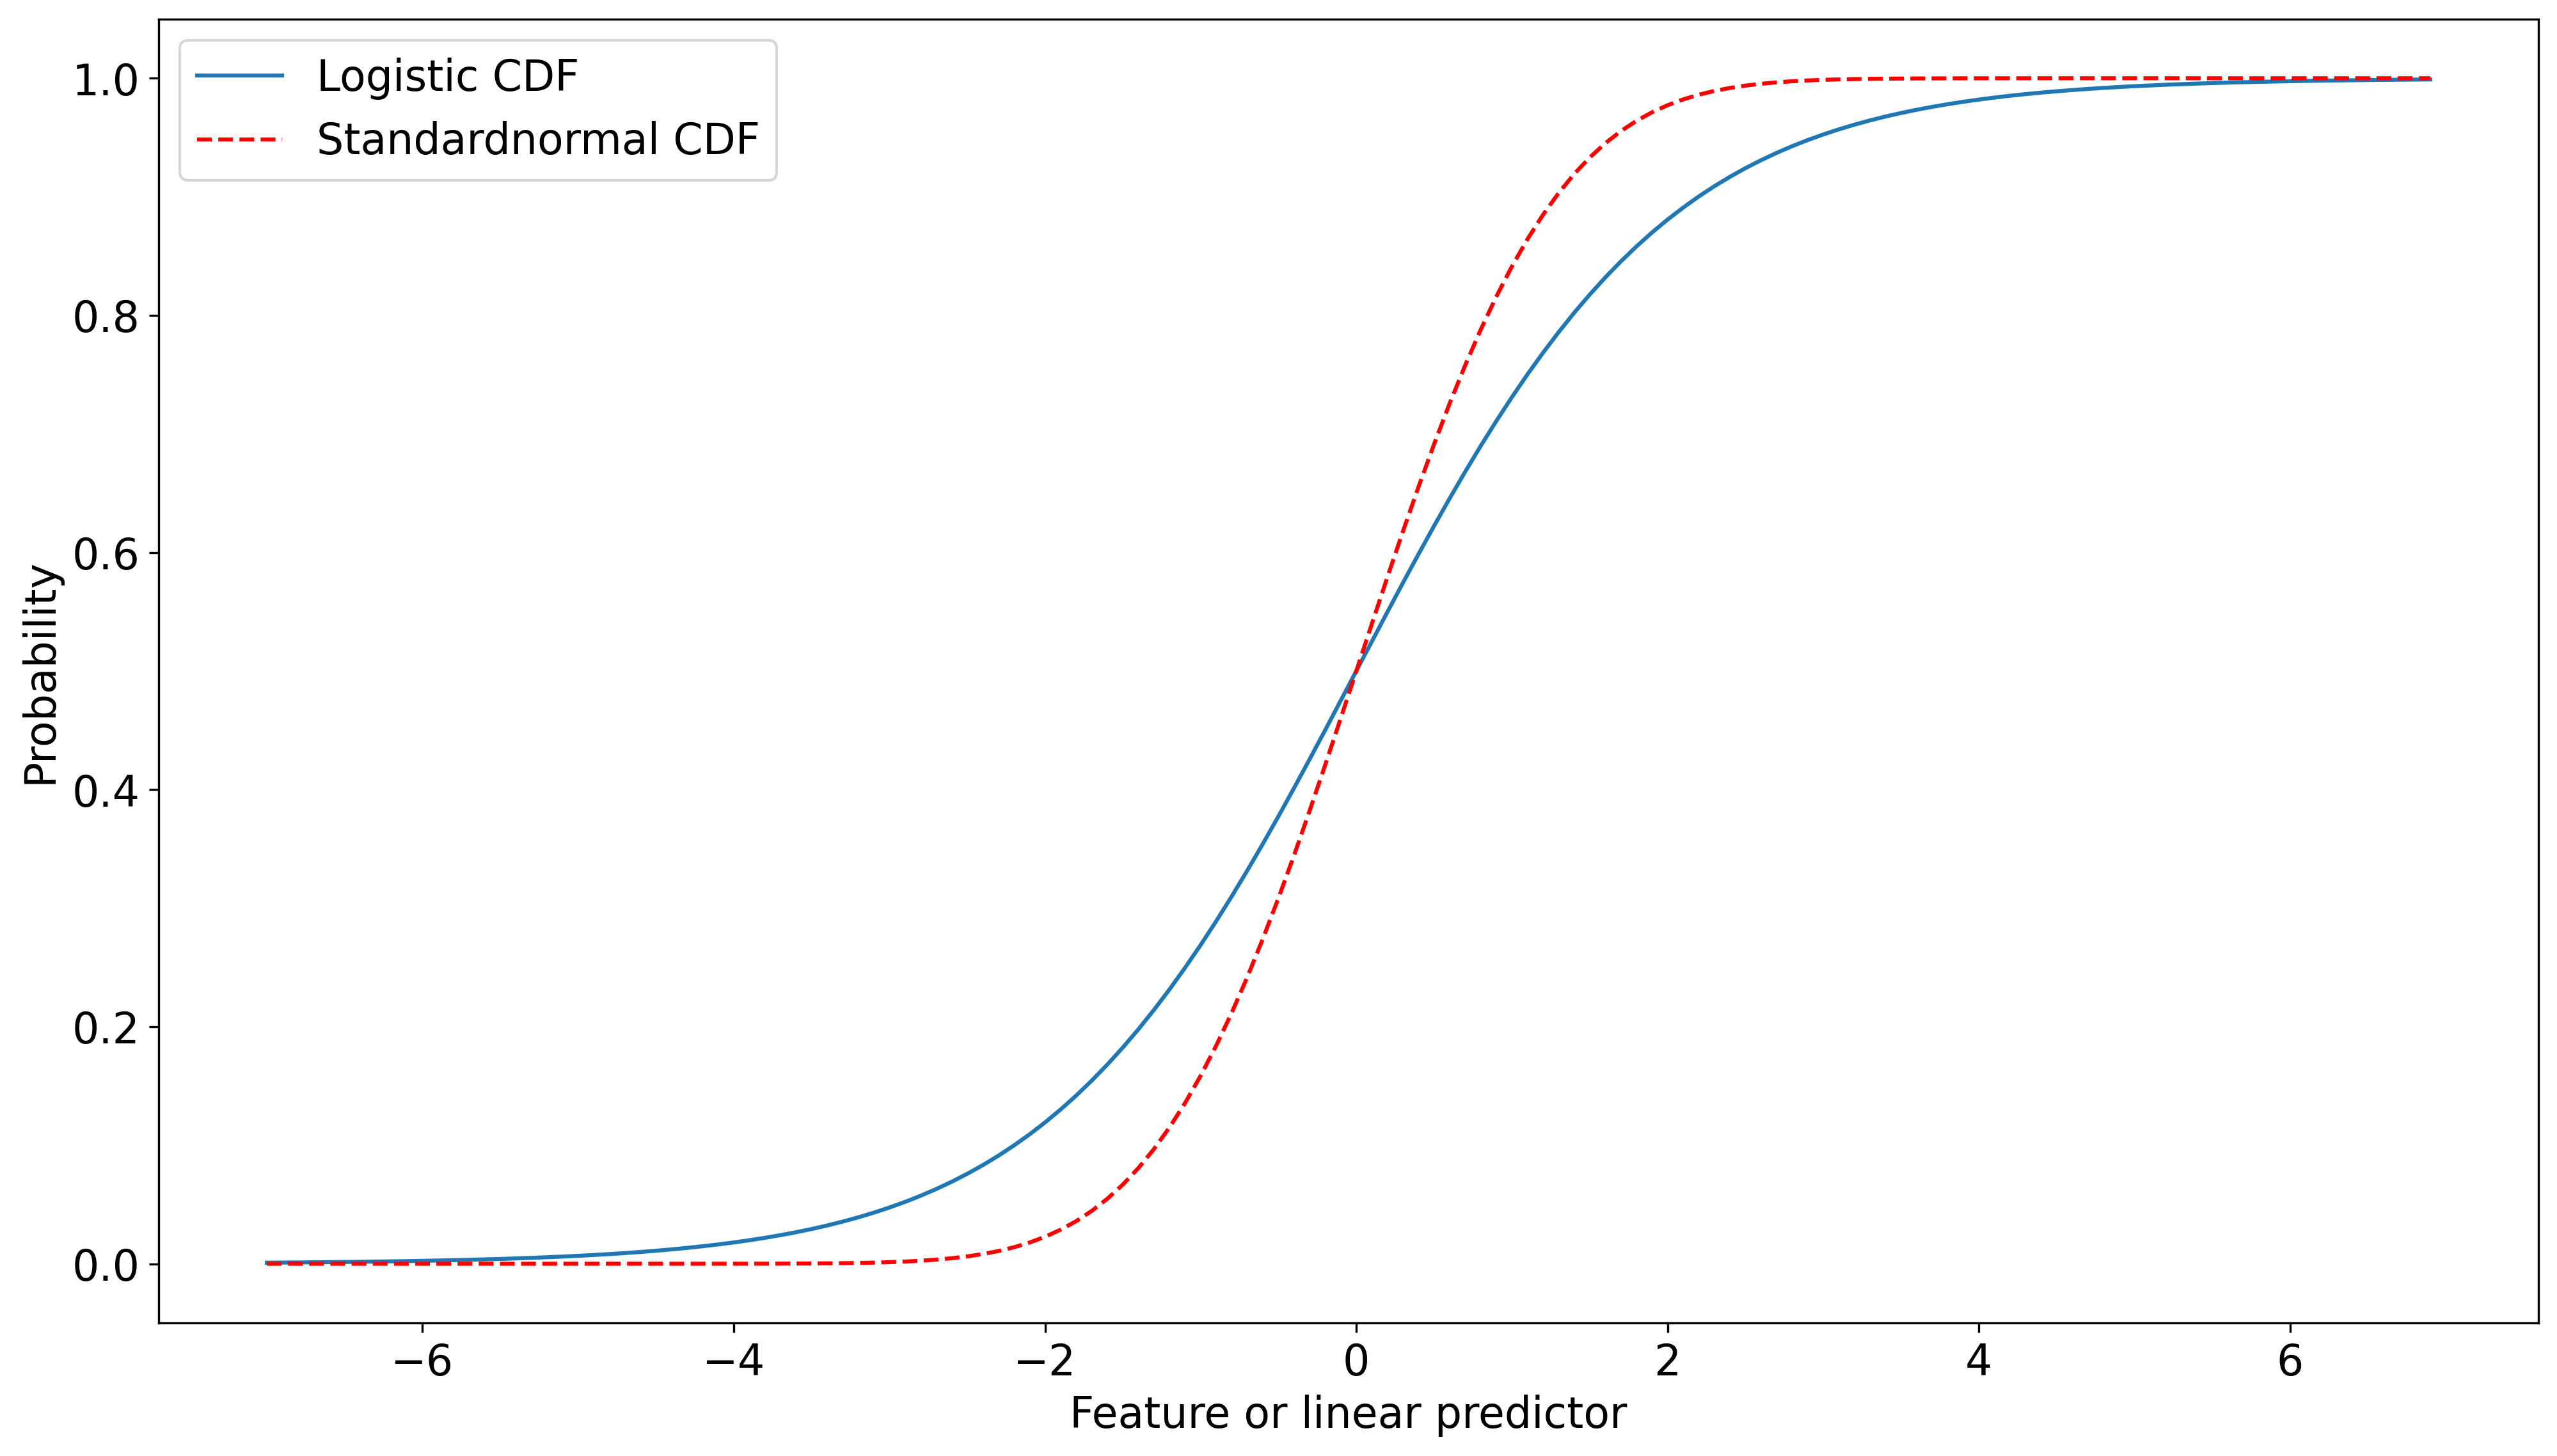

In [112]:
x=np.arange(-7, 7, 0.1)

pd_time_logit=scipy.stats.logistic.cdf(x, 0, 1)
pd_time_probit=scipy.stats.norm.cdf(x, 0, 1)

plt.plot(x,pd_time_logit,label='Logistic CDF')
plt.plot(x, pd_time_probit,color='red',label='Standardnormal CDF',linestyle='dashed')
plt.xlabel('Feature or linear predictor')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()

## Extension

 -  Extensions: multiple features
 - $\beta'x_{it}$: linear predictor (score)
 - Logit model:
\begin{align*}
PD_{it}=P(D_{it}=1|x_{it-1})=\frac{exp(\beta'x_{it-1})}{1+exp(\beta'x_{it-1})}
\end{align*}
 - Probit model:
\begin{align*}
PD_{it}=P(D_{it}=1|x_{it-1})=\Phi(\beta'x_{it-1})
\end{align*}



## Parameter Estimation

 Parameter estimation by maximizing the likelihood:
\begin{align*}
L(\beta, x_{it-1})=\prod_{i=1}^I\prod_{t=1}^T\left((P(D_{it}=1)^{d_{it}}\cdot (1-P(D_{it}=1))^{(1-d_{it})}\right)
\end{align*}

With:
 - $PD_{it}=\frac{exp(\beta'x_{it-1})}{1+exp(\beta'x_{it-1})}$  
 - $PD_{it}=\Phi(\beta'x_{it-1})$

## Probit/Logit vs OLS Models

 - No error term
 - Parameters can not be interpreted in isolation
 - No standard performance measures like r-square. All measures are data dependent


## Binomial GLM  with a Logit Link

In [113]:
glm_logit=smf.glm('default_time~cep_time',family=sm.families.Binomial(),data=data).fit()

print(glm_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                59001
Model:                            GLM   Df Residuals:                    58999
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6869.7
Date:                Mon, 15 Feb 2021   Deviance:                       13739.
Time:                        16:54:54   Pearson chi2:                 5.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6748      0.027   -138.075      0.0

## Logit Model

In [114]:
data.loc[:,'const'] = 1
y = data[['default_time']]
X = data[['const', 'cep_time']]

model_lr = sm.Logit(y,X,missing='drop').fit()

print(model_lr.summary())

Optimization terminated successfully.
         Current function value: 0.116433
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           default_time   No. Observations:                59001
Model:                          Logit   Df Residuals:                    58999
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:               0.0003203
Time:                        16:54:55   Log-Likelihood:                -6869.7
converged:                       True   LL-Null:                       -6871.9
Covariance Type:            nonrobust   LLR p-value:                   0.03590
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6748      0.027   -138.075      0.000      -3.727      -3.623
cep_time      -0.3209      0.

## Fitting PDs

\begin{align*}
\hat{PD}_{it}=\hat{P}(D_{it}=1|x_{it-1})=\frac{exp(\hat{\beta}'x_{it-1})}{1+exp(\hat{\beta}'x_{it-1})}
\end{align*}
$\hat{\beta}$ estimated parameter vector

In [115]:
PD_logit_model = pd.DataFrame(glm_logit.fittedvalues,columns=['PD_logit_model'])


## Binomial GLM  with a Probit Link

In [116]:
glm_probit = smf.glm('default_time~cep_time',family = sm.families.Binomial(sm.families.links.probit),data=data).fit()

print(glm_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                59001
Model:                            GLM   Df Residuals:                    58999
Model Family:                Binomial   Df Model:                            1
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6869.1
Date:                Mon, 15 Feb 2021   Deviance:                       13738.
Time:                        16:54:57   Pearson chi2:                 5.89e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9655      0.011   -177.059      0.0

## Fitting PDs

\begin{align*}
\hat{PD}_{it}=\hat{P}(D_{it}=1|x_{it-1})=\Phi(\hat{\beta}'x_{it-1})
\end{align*}
$\hat{\beta}$: estimated parameter vector

In [117]:
PD_probit_model=pd.DataFrame(glm_probit.fittedvalues,columns=['PD_probit_model'])

## Comparison GLM/Logit vs. GLM/Probit Model

In [118]:
data2 = pd.merge(data['default_time'],PD_logit_model,right_index=True,left_index=True)
data3 = pd.merge(data2,PD_probit_model,right_index=True,left_index=True)

print(data3.describe().round(decimals=3))                     

       default_time  PD_logit_model  PD_probit_model
count     59001.000       59001.000        59001.000
mean          0.025           0.025            0.025
std           0.156           0.002            0.002
min           0.000           0.019            0.017
25%           0.000           0.025            0.025
50%           0.000           0.025            0.025
75%           0.000           0.025            0.025
max           1.000           0.100            0.124


In [119]:
print(data3.corr(method='pearson').round(decimals=6))

                 default_time  PD_logit_model  PD_probit_model
default_time         1.000000        0.003707         0.003664
PD_logit_model       0.003707        1.000000         0.999997
PD_probit_model      0.003664        0.999997         1.000000


## Merits GLM/Logit 

Re-calibration to target levels for mean PDs:
\begin{align*}
\text{Intercept}_{target}=\text{Intercept}_{estimated}-log\left[\frac{(1-DR_{target})}{DR_{target}}\frac{DR_{observed}}{(1-DR_{observed})}\right]
\end{align*}

## Re-calibration GLM/Logit PDs

In [120]:
data2 = pd.merge(data['cep_time'], PD_logit_model, right_index=True, left_index=True)
data2.loc[:,'linear_predictor'] = -3.7049 - np.log(((1-0.05)/0.05) * (0.0244/(1-0.0244))) - 0.6700 * data2.cep_time
data2.loc[:,'PD_logit_model_target'] = np.exp(data2.linear_predictor) / (1+np.exp(data2.linear_predictor))

print(data2[['PD_logit_model','PD_logit_model_target']].describe().round(decimals=3))

       PD_logit_model  PD_logit_model_target
count       59001.000              59001.000
mean            0.025                  0.050
std             0.002                  0.011
min             0.019                  0.028
25%             0.025                  0.049
50%             0.025                  0.049
75%             0.025                  0.050
max             0.100                  0.533


## Merits GLM/Probit 

 - Assume the standard normal distribution
 - Aligned with Asymptotic Single Risk Factor Model that underlies the Basel Internal Ratings Based (IRB)


## Comprehensive Model

 1. Liquidity (`cep_time`);
 1. Equity (`equity_time`);
 1. Loan contract rate (`equity_time`);
 1. FICO credit score (`FICO_orig_time`);
 1. GDP growth rate (`gdp_time`);
 1. Principal component 1 (`PCA1_1`);
 1. Principal component 2 (`PCA2_1`);
 1. Principal component 3 (`PCA3_1`);
 1. Principal component 4 (`PCA4_1`);
 1. Principal component 5 (`PCA5_1`);
 1. Cluster 1 (`cluster_1`). 

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59001 entries, 0 to 49185
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       59001 non-null  float64 
 1   time                     59001 non-null  float64 
 2   orig_time                59001 non-null  float64 
 3   first_time               59001 non-null  float64 
 4   mat_time                 59001 non-null  float64 
 5   res_time                 1114 non-null   float64 
 6   balance_time             59001 non-null  float64 
 7   LTV_time                 59001 non-null  float64 
 8   interest_rate_time       59001 non-null  float64 
 9   rate_time                59001 non-null  float64 
 10  hpi_time                 59001 non-null  float64 
 11  gdp_time                 59001 non-null  float64 
 12  uer_time                 59001 non-null  float64 
 13  REtype_CO_orig_time      59001 non-null  float64 
 14  REtype

In [122]:
model_lr4 = smf.glm('default_time ~ cep_time + equity_time + interest_rate_time + FICO_orig_time + gdp_time + PCA1_1 + PCA2_1 + PCA3_1 + PCA4_1 + PCA5_1 + cluster_1', family = sm.families.Binomial(), data=data).fit()

print(model_lr4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                59001
Model:                            GLM   Df Residuals:                    58989
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6409.9
Date:                Mon, 15 Feb 2021   Deviance:                       12820.
Time:                        16:55:02   Pearson chi2:                 5.40e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.4398      0

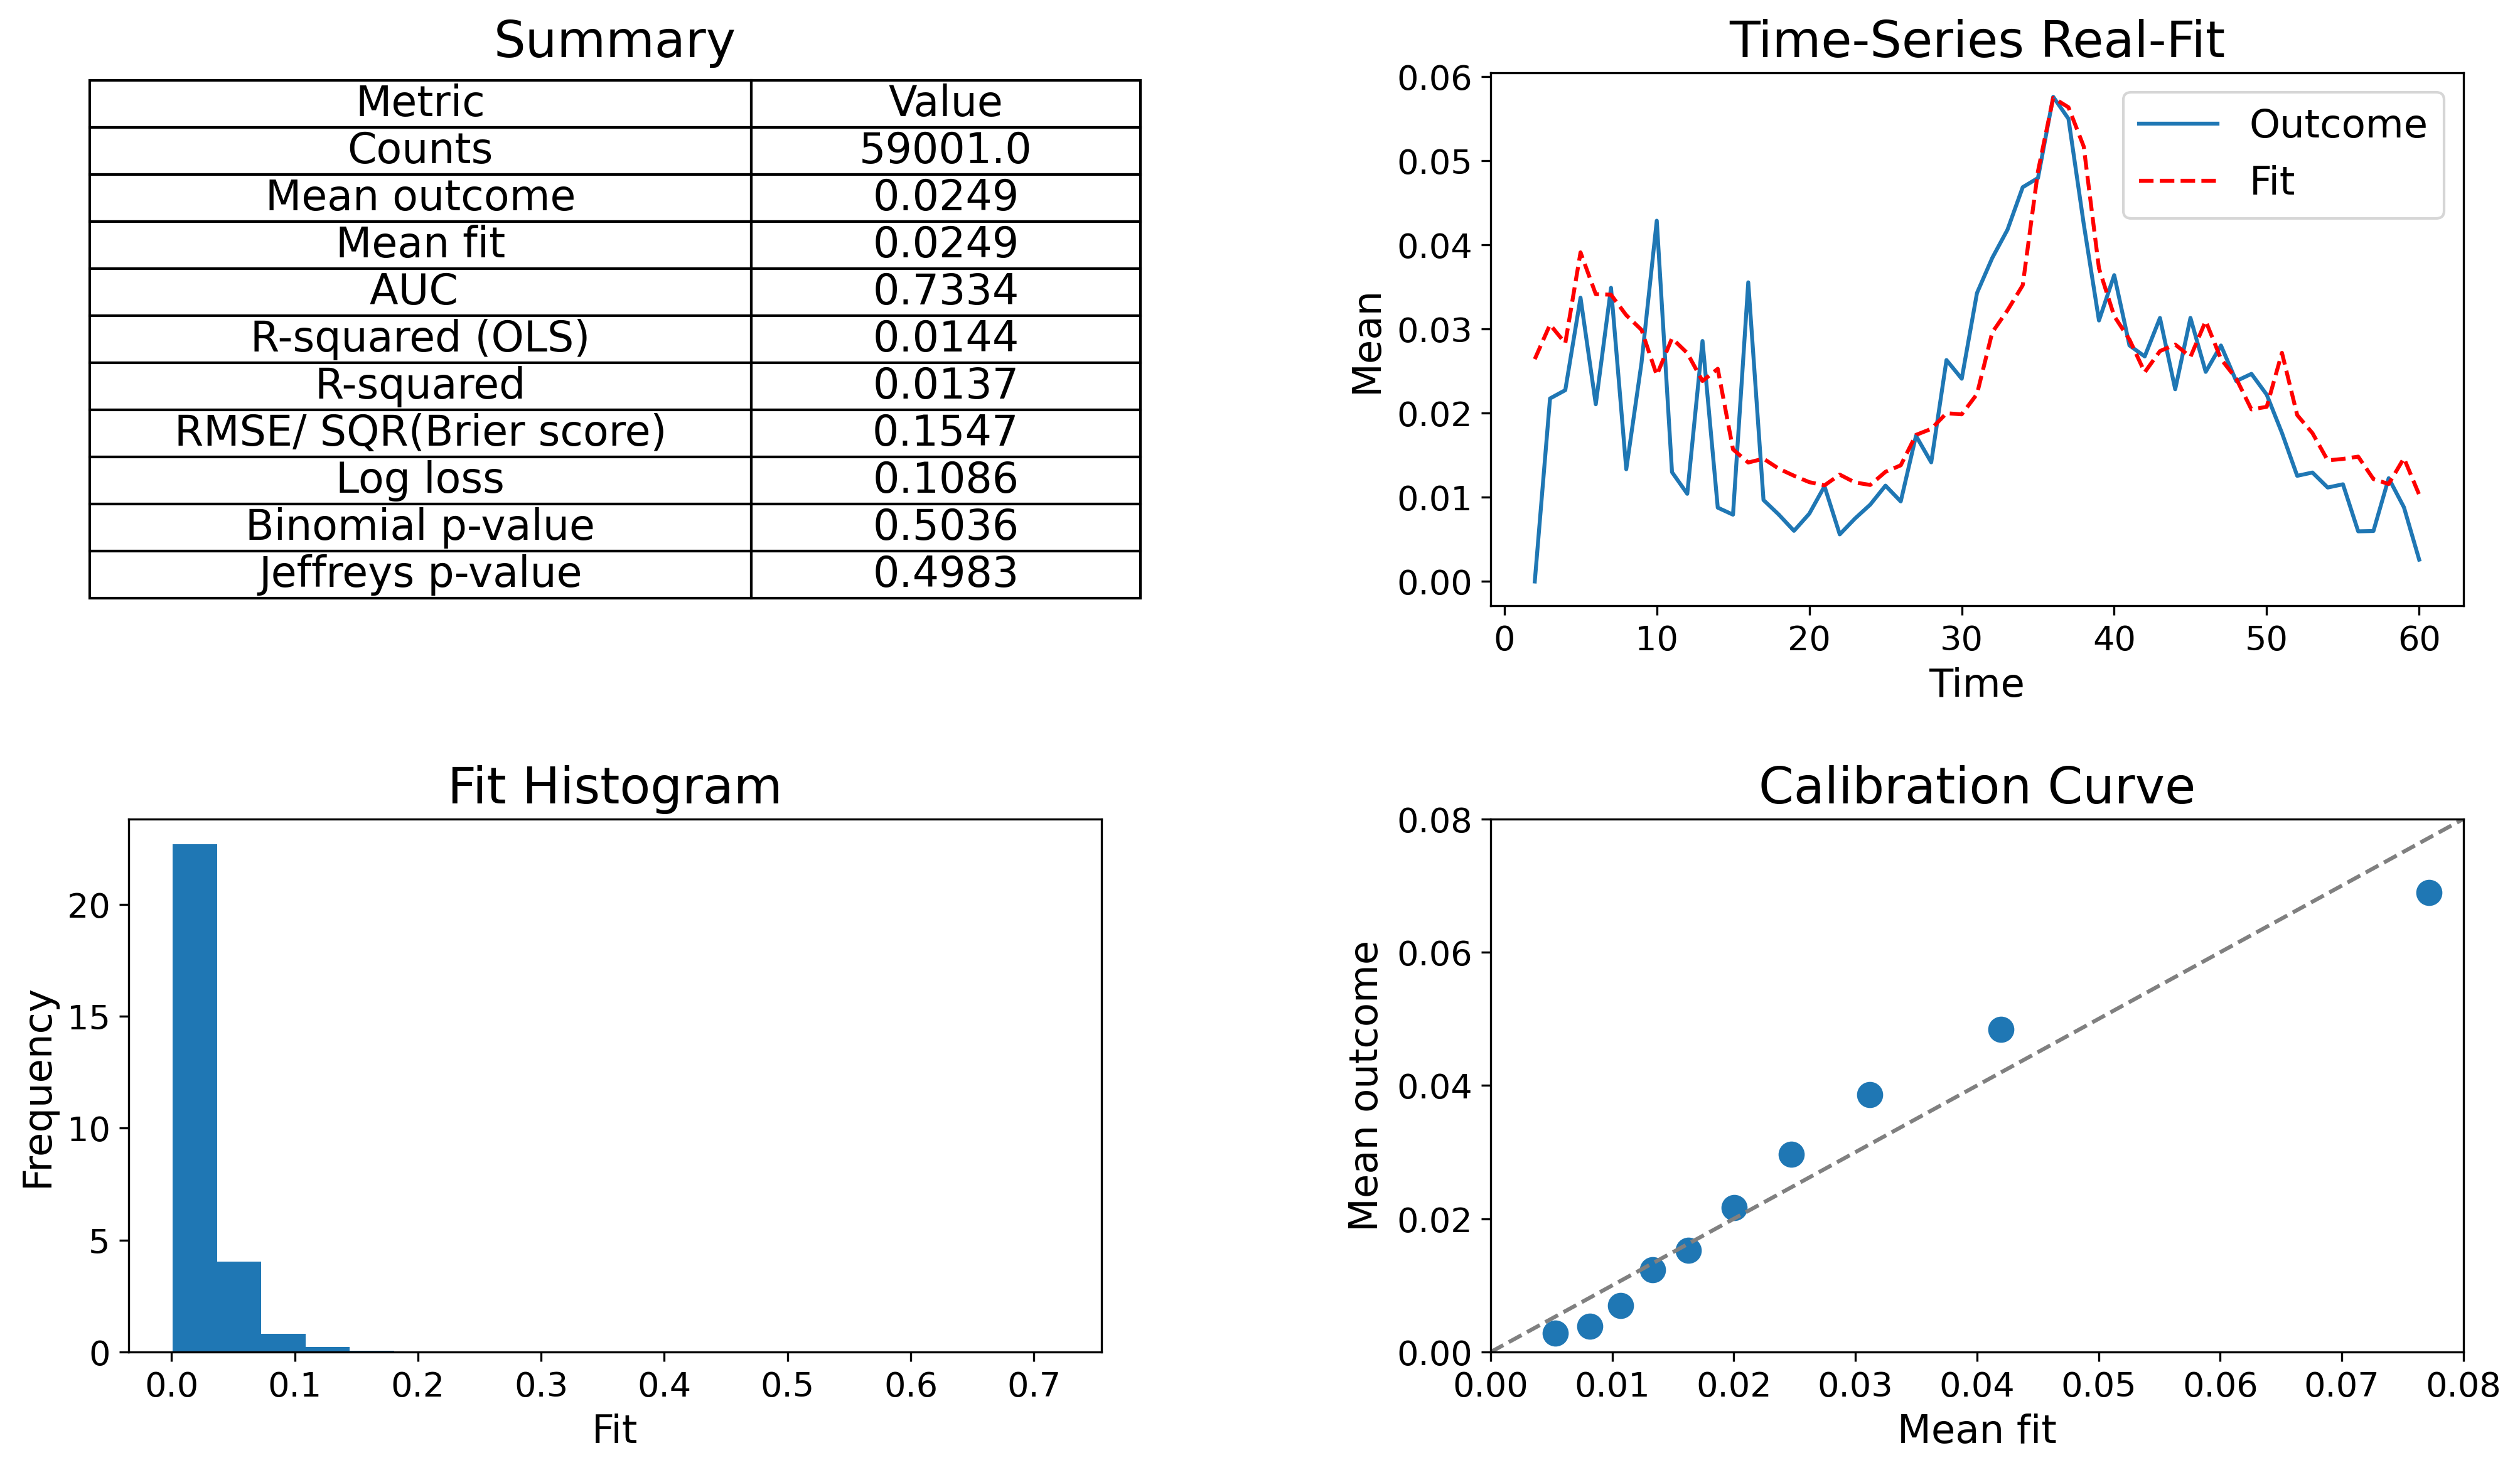

In [123]:
PD_logit_model = pd.DataFrame(model_lr4.fittedvalues, columns=['PD_logit_model'])
data2 = pd.merge(data[['default_time','time']], PD_logit_model, right_index=True, left_index=True)

validation(data2.PD_logit_model, data2.default_time, data2.time)

## Comparison `scikit-learn` vs. `statsmodels`

 - Different libraries in Python
  - `statsmodels`: risk-based learning
  - `scikit-learn`: machine learning
 - Credit risk analysts may find `statsmodels` easier for a start

In [124]:
data['const'] = 1
y = data[['default_time']]
X_const = data[['const', 'cep_time', 'equity_time', 'interest_rate_time', 'FICO_orig_time', 'gdp_time', 'PCA1_1', 'PCA2_1', 'PCA3_1', 'PCA4_1', 'PCA5_1', 'cluster_1']]

model_lr4_SM = sm.Logit(y,X_const,missing='drop').fit()

print(model_lr4_SM.summary())

Optimization terminated successfully.
         Current function value: 0.108640
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           default_time   No. Observations:                59001
Model:                          Logit   Df Residuals:                    58989
Method:                           MLE   Df Model:                           11
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                 0.06723
Time:                        16:55:05   Log-Likelihood:                -6409.9
converged:                       True   LL-Null:                       -6871.9
Covariance Type:            nonrobust   LLR p-value:                4.393e-191
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4398      0.352     -6.934      0.000      -3.129      -1.750
cep_t

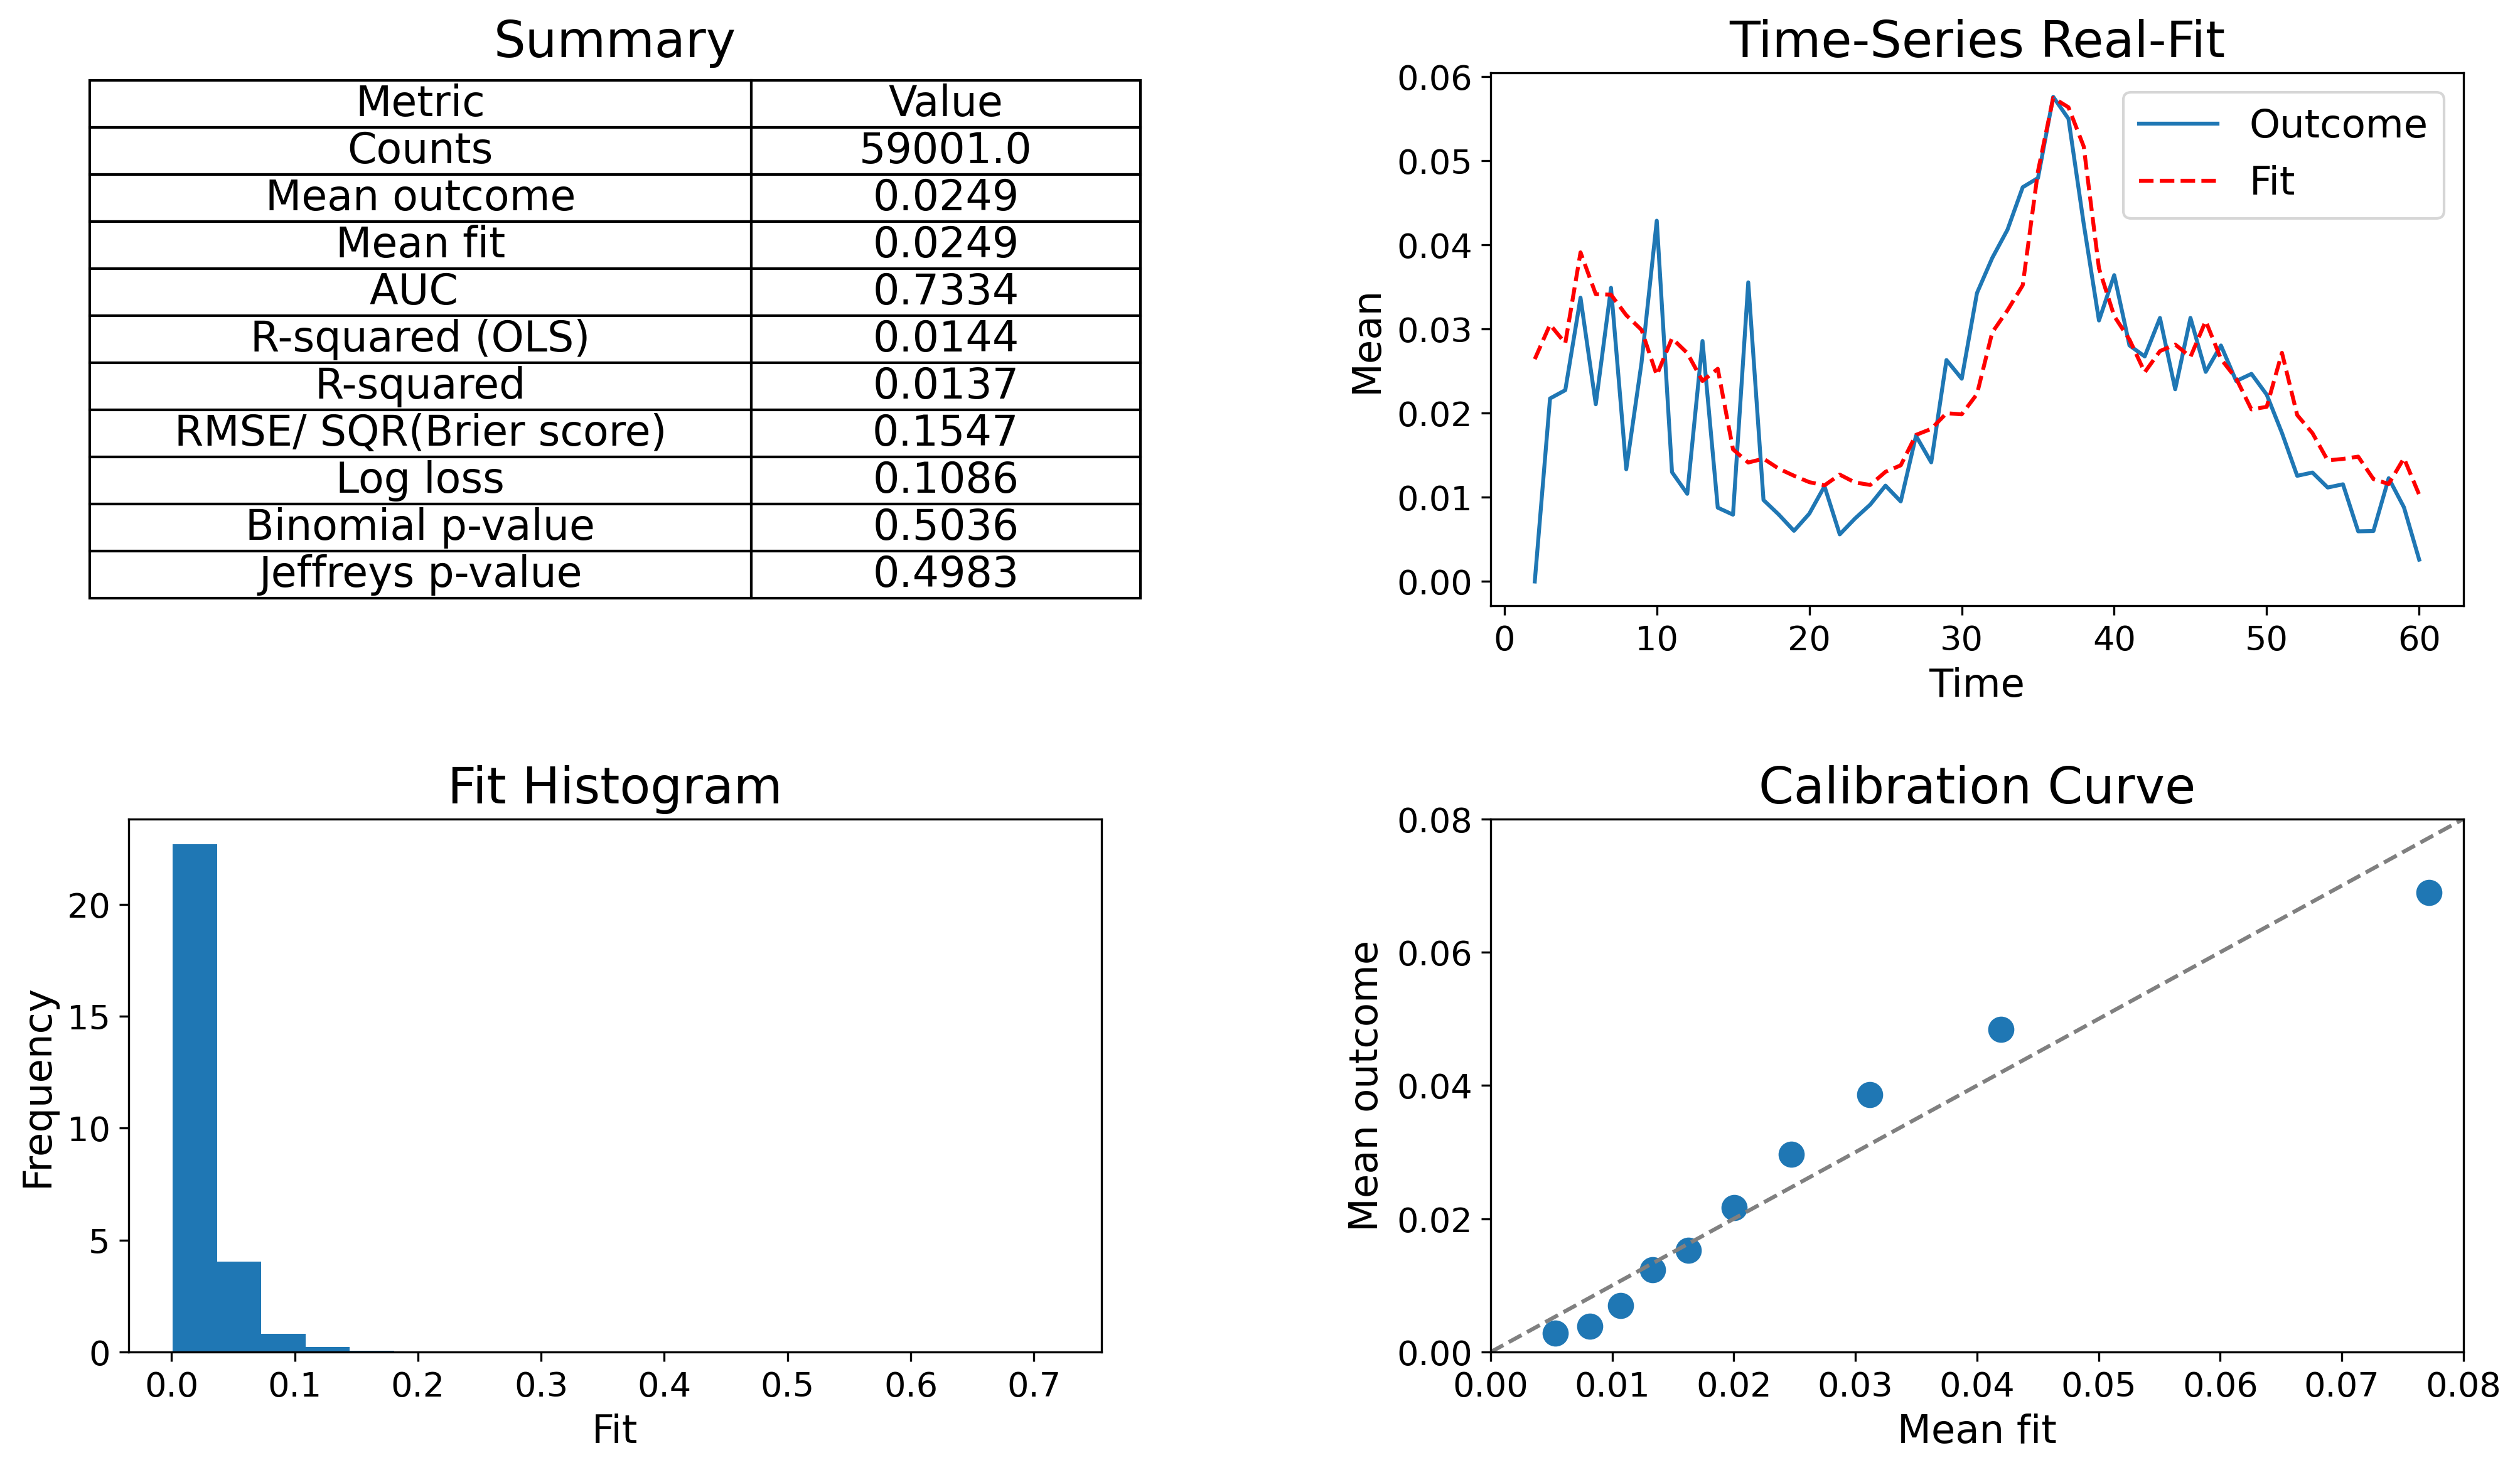

In [125]:
PD_logit_model = pd.DataFrame(1/(1+exp(-model_lr4_SM.fittedvalues)), columns=['PD_logit_model'])
data2 = pd.merge(data[['default_time','time']], PD_logit_model, right_index=True, left_index=True)

validation(data2.PD_logit_model, data2.default_time, data2.time)

In [126]:
y = data[['default_time']]
X = data[['cep_time', 'equity_time', 'interest_rate_time', 'FICO_orig_time', 'gdp_time', 'PCA1_1', 'PCA2_1', 'PCA3_1', 'PCA4_1', 'PCA5_1', 'cluster_1']]

model_lr4_SL = LogisticRegression(penalty='none', fit_intercept=True, solver='newton-cg', tol =1e-15, max_iter=10000)
model_lr4_SL.fit(X, y)

print('Coefficients:', model_lr4_SL.coef_.round(decimals=4))
print('Intercept:', model_lr4_SL.intercept_.round(decimals=4))

Coefficients: [[ 2.6636 -2.2012  0.1651 -0.0033 -0.0653  0.0107 -0.0034  0.0094  0.0151
   0.0487  0.015 ]]
Intercept: [-2.4398]


# Sandbox Problems

 - Select between the FICO score and current LTV.
 - Split the data into observations before and after `time=27`. Use the earlier sample to build a model and the later sample to select the feature that explains default best.
 - Estimate a basic credit risk model for mortgage default probabilities (PD). You may choose a Logit or a Probit model. Include two standard features which are FICO and LTV at origination. Compute the estimated PD for all mortgage loans and periods. Plot the average probability of default by time.
 - Compare the accuracy of the models from the previous two questions using function `validation`.

# Copyright and Disclaimer

Copyright: The workshop resources provided to you by Deep Credit Risk are
protected by copyright. You are not permitted to distribute or re-use the workshop materials for
commercial purposes without permission of Deep Credit Risk.

Limit of Liability/Disclaimer of Warranty: While the authors and Deep Credit Risk have used their best effort
in preparing this material, they make no representations or warranties with respect to
the accuracy or completeness of the contents and specifically disclaim any implied
warranties of merchantability or fitness for a particular purpose. No warranty may be
created or extended by sales representatives or written sales materials. The advise and
strategies contained herein may not be suitable for your situation. The authors and Deep Credit Risk shall not
be liable for any loss of profit or any other commercial damages, including but not
limited to special, incidental, consequential, or other damages.